In [62]:
import cx_Oracle as oracle
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, DateFormatter 
import numpy as np
import math
import seaborn as sns
import scipy.stats as stats  
import scipy
import scipy.cluster.vq
import scipy.spatial.distance
EuclDist = scipy.spatial.distance.euclidean
from mpl_toolkits.mplot3d import Axes3D
from factor_analyzer import FactorAnalyzer
import importlib
from sklearn import metrics,datasets,manifold
import copy
from sklearn import tree
import graphviz
import pydotplus
from six import StringIO
import os
from IPython.display import Image
import joblib
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV

# Get the data, and do the dimension reduction
Here, i get the data from the database, then do the dimension reduction  by the method of factor analysis
## Get data firstly.

In [63]:
df_feat = pd.read_csv("TotalSampleAfterProcessing.csv" , encoding = 'gbk')
df_feat.drop(columns=['Unnamed: 0'] , inplace = True)
df_feat.head(5)

CAR_NUM        F1        F2        O1        D1        O2        D2  \
0  浙AR911W  0.809524  1.000000  0.857143  0.809524  0.666667  0.714286   
1  浙AJ183G  0.047619  0.380952  0.095238  0.142857  0.047619  0.047619   
2  浙A916KS  0.285714  1.000000  0.190476  0.142857  0.380952  0.333333   
3  浙A918CJ  0.285714  0.619048  0.142857  0.142857  0.238095  0.142857   
4  浙AKB603  0.333333  0.571429  0.428571  0.380952  0.285714  0.285714   

         FS    STD_FD    AVG_FD  
0  0.630876  3.113023  6.090909  
1 -1.105313  0.547723  1.600000  
2 -1.348978  2.097060  3.210526  
3 -0.232944  5.589105  5.285714  
4 -0.341521  1.788854  3.200000

In [64]:
# 从dataframe中进行1%的抽样
df_feat_sample = df_feat.sample(n=None, frac=0.01, replace=False, weights=None, random_state=0, axis=None)
df_feat_sample = df_feat_sample.reset_index(drop=True)

In [65]:
#see the statistical indicators of the sample data
df_feat_sample.describe()

F1           F2           O1           D1           O2  \
count  4623.000000  4623.000000  4623.000000  4623.000000  4623.000000   
mean      0.270037     0.606100     0.257635     0.239712     0.217608   
std       0.256971     0.286932     0.243612     0.236694     0.210898   
min       0.047619     0.047619     0.047619     0.047619     0.047619   
25%       0.047619     0.380952     0.047619     0.047619     0.047619   
50%       0.142857     0.666667     0.142857     0.142857     0.095238   
75%       0.428571     0.857143     0.428571     0.380952     0.333333   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                D2           FS       STD_FD       AVG_FD  
count  4623.000000  4623.000000  4623.000000  4623.000000  
mean      0.229010    -1.008043     2.549642     4.127539  
std       0.212095     1.084510     1.936698     2.326158  
min       0.047619    -4.295169     0.000000     0.000000  
25%       0.047619    -1.562438     1.000000     2.500000  
50%       0.142857    -1.037803     2.380476     4.000000  
75%       0.333333    -0.266904     3.773340     5.500000  
max       1.000000     0.996411     8.927174    11.181818

In [66]:
# 在这里先将df_feat_sample保存起来，为了研究过程中抽样结果的一致性。
# df_feat_sample.to_csv("df_feat_sample.csv" , encoding = 'gbk')

In [67]:
# read data from the pre-saved data
df_feat_sample = pd.read_csv("df_feat_sample.csv", encoding = 'gbk')
df_feat_sample.drop(columns=['Unnamed: 0'] , inplace = True)
df_feat_sample.head(5)

CAR_NUM        F1        F2        O1        D1        O2        D2  \
0  浙AFZ391  0.047619  0.904762  0.142857  0.142857  0.571429  0.619048   
1  浙B732UE  0.047619  0.428571  0.047619  0.047619  0.047619  0.047619   
2  浙AN0G37  0.428571  0.952381  0.523810  0.523810  0.523810  0.523810   
3  浙A3WA22  0.047619  0.571429  0.047619  0.047619  0.285714  0.333333   
4  浙GN820X  0.476190  0.857143  0.476190  0.285714  0.285714  0.523810   

         FS    STD_FD    AVG_FD  
0 -2.000000  2.093641  5.125000  
1 -1.453860  1.118034  2.333333  
2 -0.677038  2.547726  4.909091  
3 -1.199703  2.958040  3.666667  
4 -0.820671  5.780846  5.727273

## Dimension reduction

In this part, i will do the dimension reduction by the factor analysis.

### Choosing the Number of Factors

In [68]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors = 9, rotation='varimax', method='principal', use_smc=True, \
                    is_corr_matrix=False, bounds=(0.005, 1), impute='median', rotation_kwargs=None)
fa.fit(df_feat_sample[['F1' , 'F2' , 'O1' , 'D1' , 'O2' , 'D2' , 'FS' , 'STD_FD' , 'AVG_FD']])
# Check Eigenvalues
factor_ev = fa.get_eigenvalues()
factor_ev

(array([4.73873204, 1.8188256 , 0.9094108 , 0.55263826, 0.3704023 ,
        0.24765782, 0.16004038, 0.12240567, 0.07988715]),
 array([4.73873204, 1.8188256 , 0.9094108 , 0.55263826, 0.3704023 ,
        0.24765782, 0.16004038, 0.12240567, 0.07988715]))

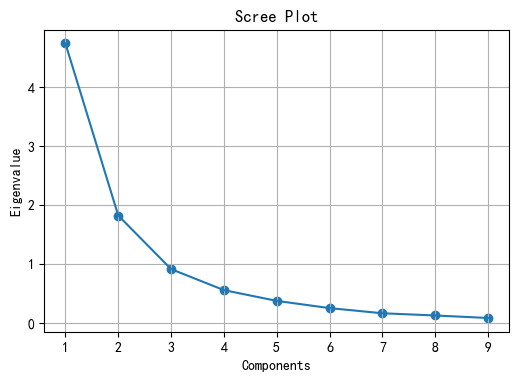

In [69]:
# Create scree plot using matplotlib
plt.rcParams['font.sans-serif'] = ['SimHei']  #显示中文字符
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号
plt.rcParams['figure.dpi'] = 100 #图片像素
plt.scatter(range(1,df_feat_sample.shape[1]),factor_ev[1])
plt.plot(range(1,df_feat_sample.shape[1]),factor_ev[1])
plt.title('Scree Plot')
plt.xlabel('Components')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [70]:
# Calculate the factor variance information, including variance, proportional variance and cumulative variance for each factor.
# 1. Sum of squared loadings (variance)
# 2. Proportional variance
# 3. Cumulative variance
factor_variance = fa.get_factor_variance()
factor_variance

(array([2.45404171, 2.11969221, 1.11573775, 1.03857742, 0.91038504,
        0.90374638, 0.25355476, 0.118127  , 0.08613773]),
 array([0.2726713 , 0.23552136, 0.12397086, 0.11539749, 0.10115389,
        0.10041626, 0.02817275, 0.01312522, 0.00957086]),
 array([0.2726713 , 0.50819266, 0.63216352, 0.74756101, 0.8487149 ,
        0.94913117, 0.97730392, 0.99042914, 1.        ]))

In [71]:
# see the factors' loadings
pd.DataFrame(fa.loadings_)

0         1         2         3         4         5         6  \
0  0.642595  0.520488  0.039392  0.141357  0.058061  0.224747  0.490657   
1  0.401459  0.359925  0.092731  0.033167  0.159006  0.818804  0.062139   
2  0.892432  0.320055 -0.016298  0.099669 -0.010793  0.218011  0.041187   
3  0.886677  0.339429 -0.043627  0.124019 -0.038802  0.185638  0.020372   
4  0.383513  0.857136 -0.057268  0.107485 -0.034716  0.192692  0.048660   
5  0.363498  0.866686 -0.028835  0.110198 -0.013491  0.212216  0.059132   
6  0.130681  0.116006  0.004334  0.983743 -0.018573  0.025438  0.026511   
7 -0.021097 -0.023752  0.459091 -0.025964  0.878569  0.124302  0.014618   
8 -0.024013 -0.041749  0.942615  0.007729  0.326333  0.050413  0.007560   

          7         8  
0 -0.000078 -0.001993  
1  0.001323  0.000408  
2 -0.018023 -0.203135  
3  0.021384  0.210873  
4  0.249954  0.014937  
5 -0.234223 -0.013214  
6  0.000522  0.000880  
7 -0.001459 -0.001407  
8 -0.001789 -0.001267

so, I choose 3 factors based on the principal of eigenvalues greater then 1.

### Performing Factor Analysis

In [72]:
# Create factor analysis object and perform factor analysis using 5 factors
fa = FactorAnalyzer(n_factors = 3, rotation='varimax', method='principal', use_smc=True, \
                    is_corr_matrix=False, bounds=(0.005, 1), impute='median', rotation_kwargs=None)
fa.fit(df_feat_sample[['F1' , 'F2' , 'O1' , 'D1' , 'O2' , 'D2' , 'FS' , 'STD_FD' , 'AVG_FD']])
fa.loadings_

array([[ 0.9117434 ,  0.06458854,  0.15205703],
       [ 0.80155861,  0.28493596, -0.04960228],
       [ 0.89217186, -0.03025734,  0.10614231],
       [ 0.88641902, -0.07932703,  0.13627148],
       [ 0.87323388, -0.10114568,  0.10527671],
       [ 0.87187984, -0.05806726,  0.10580668],
       [ 0.18535326, -0.00653933,  0.97736579],
       [ 0.02614182,  0.93052244, -0.05183417],
       [-0.03774824,  0.9181832 ,  0.03922065]])

In [73]:
x = fa.loadings_
x = pd.DataFrame(x)
x

0         1         2
0  0.911743  0.064589  0.152057
1  0.801559  0.284936 -0.049602
2  0.892172 -0.030257  0.106142
3  0.886419 -0.079327  0.136271
4  0.873234 -0.101146  0.105277
5  0.871880 -0.058067  0.105807
6  0.185353 -0.006539  0.977366
7  0.026142  0.930522 -0.051834
8 -0.037748  0.918183  0.039221

In [74]:
# Calculate the factor variance information, including variance, proportional variance and cumulative variance for each factor.
# 1. Sum of squared loadings (variance)
# 2. Proportional variance
# 3. Cumulative variance
factor_variance = fa.get_factor_variance()
factor_variance

(array([4.61465757, 1.81514586, 1.037165  ]),
 array([0.51273973, 0.20168287, 0.11524056]),
 array([0.51273973, 0.7144226 , 0.82966316]))

In [75]:
# see the eigenvalues
fa.get_eigenvalues()

(array([4.73873204, 1.8188256 , 0.9094108 , 0.55263826, 0.3704023 ,
        0.24765782, 0.16004038, 0.12240567, 0.07988715]),
 array([ 4.54198454e+00,  1.67073505e+00,  8.87829058e-01,  3.46499536e-01,
         1.60404388e-01,  6.65621855e-02,  1.67424546e-03, -8.99107766e-02,
        -1.18809797e-01]))

### Get the new features' score

In [76]:
df_feat_new = fa.transform(df_feat_sample[['F1' , 'F2' , 'O1' , 'D1' , 'O2' , 'D2' , 'FS' , 'STD_FD' , 'AVG_FD']])
df_feat_new = pd.DataFrame(df_feat_new)
df_feat_new['CAR_NUM'] = df_feat_sample['CAR_NUM']
df_feat_new.rename(columns = {0 : 'f1' , 1 : 'f2' , 2 : 'f3'} , inplace = True)
df_feat_new.head(5)

f1        f2        f3  CAR_NUM
0  0.633961  0.057235 -1.165552  浙AFZ391
1 -0.878013 -0.763536 -0.307468  浙B732UE
2  1.312621  0.156470  0.043351  浙AN0G37
3 -0.335299 -0.023774 -0.200037  浙A3WA22
4  0.847105  1.263833 -0.014173  浙GN820X

In [77]:
df_feat_new.describe()

f1            f2            f3
count  4.623000e+03  4.623000e+03  4.623000e+03
mean  -5.792468e-17 -2.264634e-17  2.207238e-16
std    1.000108e+00  1.000108e+00  1.000108e+00
min   -1.408927e+00 -1.836644e+00 -3.331709e+00
25%   -8.057797e-01 -7.140758e-01 -5.158000e-01
50%   -3.135497e-01 -5.802492e-02 -4.925415e-02
75%    6.600085e-01  6.362371e-01  6.788130e-01
max    3.262468e+00  3.412270e+00  2.275098e+00

### Understand the new factors

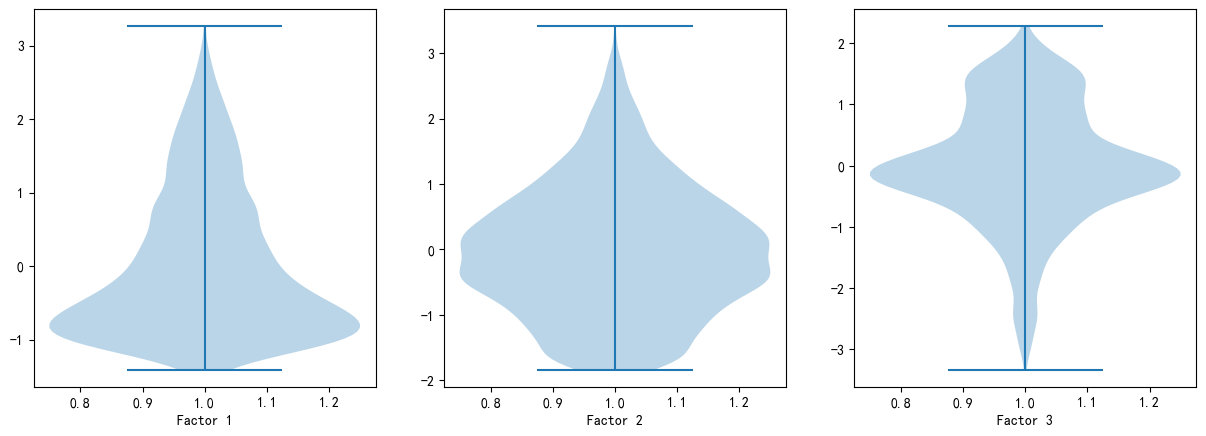

In [78]:
# plot the box plot, so that we can see the distribution of all the features.
fig,(ax1, ax2, ax3) = plt.subplots(1, 3, sharex = True,figsize=(15, 5))
# ax1 = plt.subplot(3, 3, 1,figsize=(10, 11))
ax1.violinplot(df_feat_new["f1"] )
ax1.set_xlabel('Factor 1')
# # ax2 = plt.subplot(3, 3, 2)
ax2.violinplot(df_feat_new["f2"] )
ax2.set_xlabel('Factor 2')
ax3.violinplot(df_feat_new["f3"] )
ax3.set_xlabel('Factor 3')
# plt.savefig('子样本车辆分布情况_new.png')
plt.show()

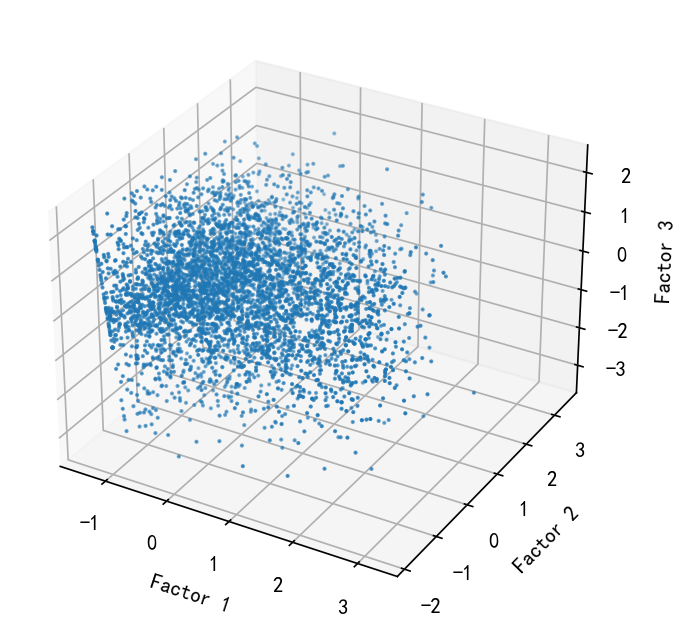

In [80]:
#将降维后的3个因子可视化展示出来
plt.rcParams['figure.dpi'] = 150 #分辨率
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(df_feat_new['f1'] , df_feat_new['f2'] , df_feat_new['f3'] , s = 1, c=None )
ax.set_xlabel("Factor 1") ; ax.set_ylabel("Factor 2") ; ax.set_zlabel("Factor 3") 
plt.show()

# Commuting Pattern recognition

From then on, I start to get the commuting vehicles. The general process is clustering ths sample firstly, then train the decision tree model to get the commuting rule.

## Get the optimal number of the clusters
Here i try to get the optimal cluster number by the gap statistic method.

E:\Anaconda\lib\site-packages\scipy\cluster\vq.py:574: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


gaps: [0.44715245 0.43314783 0.45948223 0.44319516 0.41633712 0.40196826
 0.40662059 0.39496477 0.37610097]
gaps_diff: [ 0.02486359 -0.00571009  0.02299478  0.03104133  0.01768958 -0.00178513
  0.02403709  0.03202931]


E:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


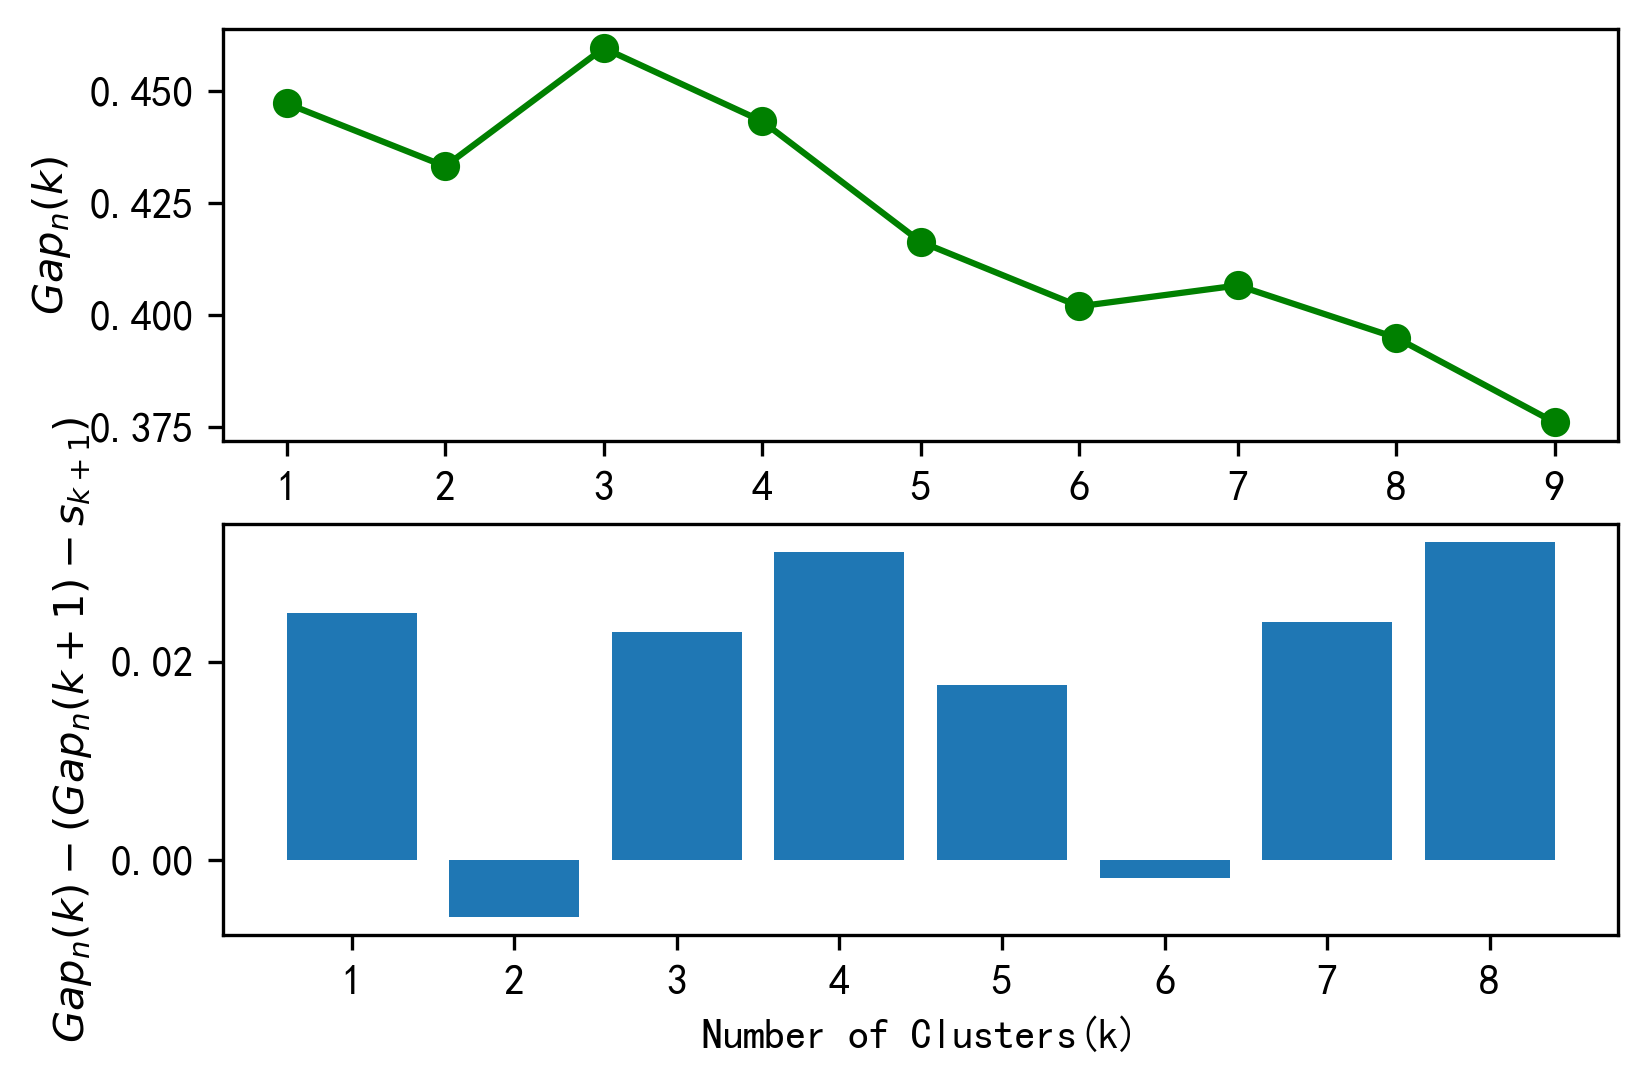

In [81]:
# 利用本地的GAP_STATISTICS包里的代码得到gap(k)随着聚类数目k的改变而变化的图
from GAP_STATISTICS import gapStat
plt.rcParams['figure.dpi'] = 300 #分辨率
gaps , gapsDiff = gapStat(df_feat_new[['f1' , 'f2' , 'f3']].values)
print("gaps:" , gaps)
print("gaps_diff:",gapsDiff)

# plot the gap(k) and the Gap(k)-(Gap(k+1)-sk+1) Varying with the Number of Clusters
x_axis = range(1 , 10)
f, (a1,a2) = plt.subplots(2,1)
a1.plot(x_axis , gaps, 'g-o')
a1.set_ylabel(r'$Gap_n(k)$')
a2.bar(np.arange(1 , len(gapsDiff) + 1),gapsDiff)
a2.set_xlabel("Number of Clusters(k)")
a2.set_ylabel(r'$Gap_n(k)-(Gap_n(k+1)-s_{k+1})$')
f.show()

## DBSCAN

I have got the optimal clustering number that is 3. From then on, i will start to use several clustering method to identify the commuting vehicles. Firstly, i would like to try the DBSCAN method.

### The initial parameters of DBSCAN determination 

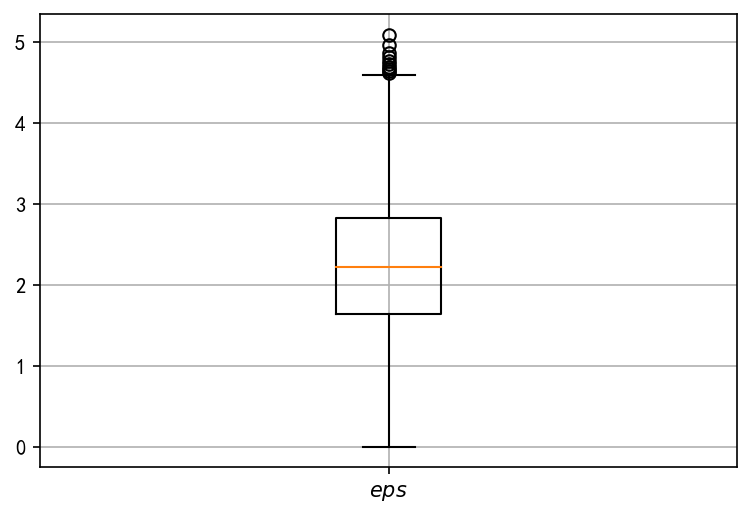

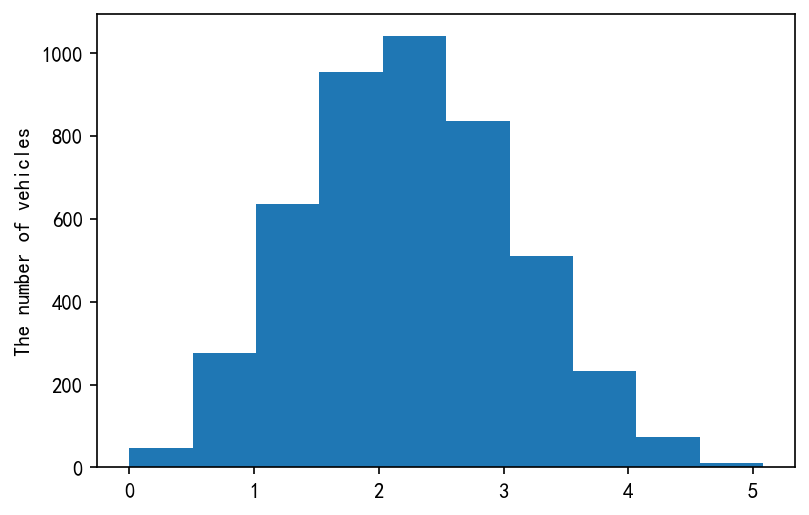

The fourth eps in the eps array is :  0.2143134550456535


In [82]:
# 根据周红芳的论文中的方法来确定DBSCAN的2个初始参数.
# Firstly, I would like to get the eps
from DBSCANRelatedFunction import GetEps
# importlib.reload(DBSCANRelatedFunction)
eps_array = GetEps(df = df_feat_new[['f1' , 'f2' , 'f3']])
print("The fourth eps in the eps array is : " , eps_array[4])

In [83]:
# secondly, I would like to get the minPts
from DBSCANRelatedFunction import GetMinPts
# importlib.reload(DBSCANRelatedFunction)
minPts = GetMinPts(df = df_feat_new[['f1' , 'f2' , 'f3']] , eps = eps_array[4])
print("The best minPts is : " , minPts)

The best minPts is :  7.767683322517845


### DBSCAN Clustering

每个样本的簇标号:
[ 1  0 -1 ... -1 -1  0]
噪声比: 47.67%
分簇的数目: 34
轮廓系数: -0.247


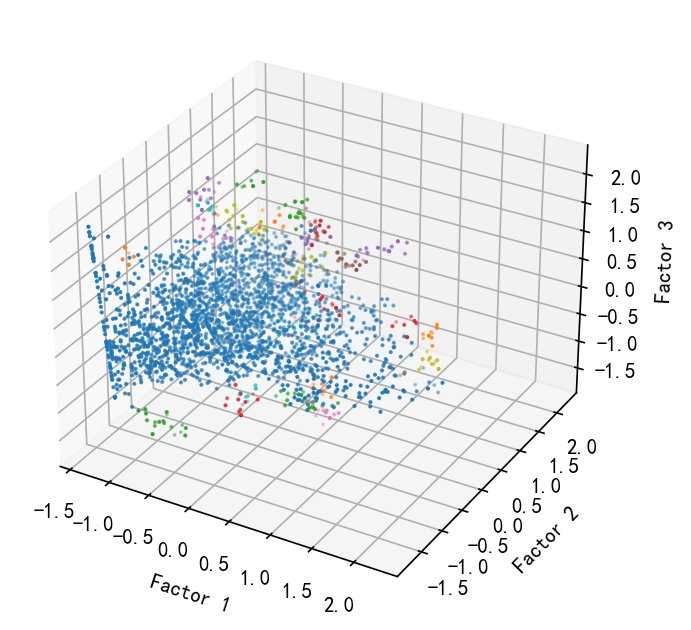

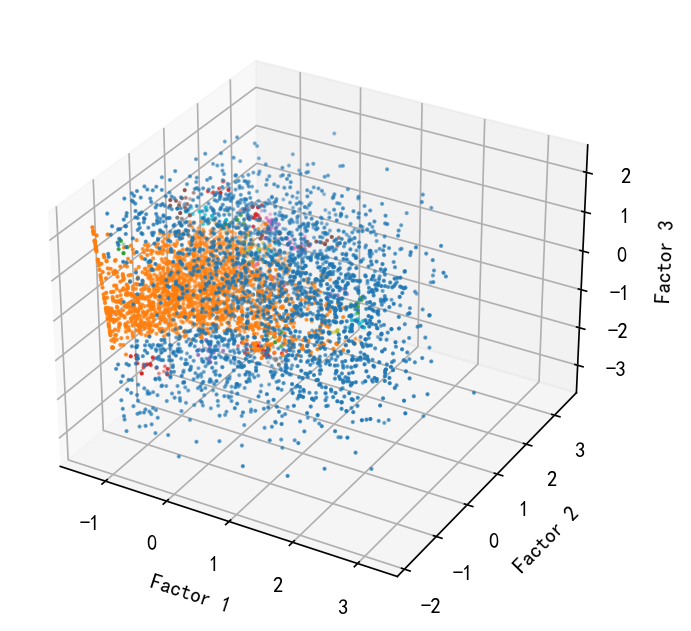

In [84]:
from DBSCANRelatedFunction import DBSCAN
# importlib.reload(DBSCANRelatedFunction)
labels = DBSCAN(df = df_feat_new[['f1' , 'f2' , 'f3']] , eps_set = 0.2143 , MinPts = 8 )

In [85]:
# Analyse the result of the DBSCAN clustering
df_feat_new['DBSCAN'] = labels
# 其中聚类结果中最大的簇为第0个簇，有2178辆车，得到该簇的统计信息
df_feat_new = pd.merge(df_feat_new , df_feat_sample , on = ['CAR_NUM'] , how = 'inner')
df_feat_new.head(5)

f1        f2        f3  CAR_NUM  DBSCAN        F1        F2  \
0  0.633961  0.057235 -1.165552  浙AFZ391       1  0.047619  0.904762   
1 -0.878013 -0.763536 -0.307468  浙B732UE       0  0.047619  0.428571   
2  1.312621  0.156470  0.043351  浙AN0G37      -1  0.428571  0.952381   
3 -0.335299 -0.023774 -0.200037  浙A3WA22       0  0.047619  0.571429   
4  0.847105  1.263833 -0.014173  浙GN820X      -1  0.476190  0.857143   

         O1        D1        O2        D2        FS    STD_FD    AVG_FD  
0  0.142857  0.142857  0.571429  0.619048 -2.000000  2.093641  5.125000  
1  0.047619  0.047619  0.047619  0.047619 -1.453860  1.118034  2.333333  
2  0.523810  0.523810  0.523810  0.523810 -0.677038  2.547726  4.909091  
3  0.047619  0.047619  0.285714  0.333333 -1.199703  2.958040  3.666667  
4  0.476190  0.285714  0.285714  0.523810 -0.820671  5.780846  5.727273

In [86]:
# see the biggest cluster's statistical infomation
df_feat_new[df_feat_new['DBSCAN'] == 0].describe()

f1           f2           f3  DBSCAN           F1  \
count  2056.000000  2056.000000  2056.000000  2056.0  2056.000000   
mean     -0.509467    -0.184230    -0.080041     0.0     0.142510   
std       0.605167     0.815186     0.465648     0.0     0.142020   
min      -1.364080    -1.779969    -1.185855     0.0     0.047619   
25%      -0.952084    -0.769789    -0.357086     0.0     0.047619   
50%      -0.681525    -0.161238    -0.113528     0.0     0.095238   
75%      -0.249902     0.429047     0.143619     0.0     0.190476   
max       1.781952     1.700654     2.139364     0.0     0.904762   

                F2           O1           D1           O2           D2  \
count  2056.000000  2056.000000  2056.000000  2056.000000  2056.000000   
mean      0.488327     0.142880     0.128822     0.124189     0.136395   
std       0.270258     0.150280     0.137450     0.121399     0.128306   
min       0.047619     0.047619     0.047619     0.047619     0.047619   
25%       0.238095     0.047619     0.047619     0.047619     0.047619   
50%       0.476190     0.095238     0.047619     0.095238     0.095238   
75%       0.714286     0.142857     0.142857     0.142857     0.142857   
max       1.000000     0.952381     0.904762     0.857143     0.809524   

                FS       STD_FD       AVG_FD  
count  2056.000000  2056.000000  2056.000000  
mean     -1.183317     2.218592     3.710175  
std       0.458078     1.599549     1.989572  
min      -2.464318     0.000000     0.000000  
25%      -1.440093     0.957427     2.400000  
50%      -1.141871     2.163457     3.600000  
75%      -1.000000     3.354917     5.000000  
max       0.990016     7.204165    11.000000

## ISODATA Clustering

### Get the initial parameters of ISODATA by the kmeans

In [207]:
import k_means_cluster
from max_min_cluster import get_distance
result = k_means_cluster.k_means_cluster(df_feat_new[['f1' , 'f2' , 'f3']].values , 3)
result

[[array([ 0.63396088,  0.05723516, -1.16555231]),
  array([ 0.84710534,  1.26383289, -0.01417255]),
  array([-0.37747135,  0.11295772, -0.15800405]),
  array([0.72452982, 1.53138035, 1.70853138]),
  array([-0.45757533,  0.92513296,  0.82505124]),
  array([-0.04388197,  0.42247264, -0.0647826 ]),
  array([-0.89865666,  2.5771406 ,  0.18062256]),
  array([-0.6429409 ,  0.62700037, -0.2861031 ]),
  array([ 0.38066193,  0.12140998, -1.09114632]),
  array([ 0.38993321,  0.47727149, -0.45567808]),
  array([-0.55689067,  0.58459735,  0.01096489]),
  array([-0.65807526,  0.67965687, -0.15508679]),
  array([0.21332963, 0.83853658, 0.12939905]),
  array([-0.25361311,  1.31215145, -0.36571314]),
  array([-0.80636449,  0.64907786,  0.04485982]),
  array([-0.59744551,  0.81517692,  0.8404408 ]),
  array([-0.58711568,  0.92494758,  0.35568915]),
  array([ 0.51983573,  0.50231169, -0.338939  ]),
  array([-0.27275897,  0.14749072, -0.2574021 ]),
  array([-0.06945247,  1.23296242, -0.1122991 ]),
  arra

各个簇的样本个数: [1632, 1812, 1179]
各个簇的标准差最大分量: [1.00419530633098, 0.932311982173369, 0.9450386081567261]
各个簇中心间的距离: [1.7647008995850917, 2.1417655652416903, 2.116485100906183]


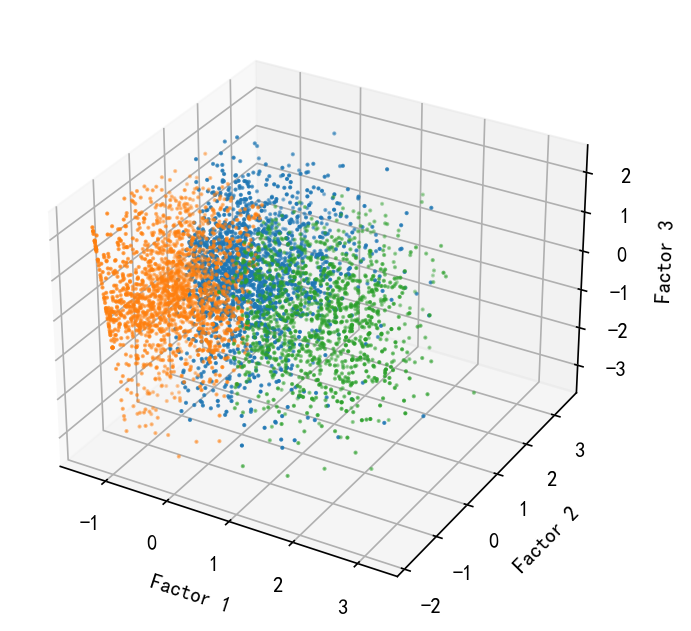

In [105]:
# define two function that the cell needs
def get_dis_sta(df):
    #获得某个cluster的距离标准差的最大分量
    sta = []
    for i in range(df.shape[1]):
        #print(df.iloc[:,i])
        sta.append(df.iloc[:,i].std())
    x = max(sta)
    return x

def get_cen_dis(list_cen):
    #计算所有簇的中心点间的两两的距离
    dis_cen = []
    for i in range(len(list_cen) - 1):
        for j in range(i+1 , len(list_cen)):
            dis_cen.append(get_distance(list_cen[i] , list_cen[j]))
    return dis_cen

# show the result of the kmeans clustering, and get the parameters that ISODATA clustering needs
plt.rcParams['figure.dpi'] = 150 #分辨率
cluster_num = []   #记录各个簇的样本数量
cluster_sta = []   #记录各个簇的标准差最大分量
cluster_cen = []   #记录各个簇的簇中心点

fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel("Factor 1") ; ax.set_ylabel("Factor 2") ; ax.set_zlabel("Factor 3") 

for cluster in result:
    df_clu = pd.DataFrame(cluster)
    df_clu.rename(columns = {0 : 'f1' , 1 : 'f2' , 2 : 'f3'} , inplace = True)
    cluster_num.append(df_clu.shape[0])
    cluster_sta.append(get_dis_sta(df_clu))
    cluster_cen.append([df_clu.mean()[0] , df_clu.mean()[1] , df_clu.mean()[2]])
    ax.scatter(df_clu['f1'] , df_clu['f2'] , df_clu['f3'] , s = 1, c=None )
    
dis_cen = get_cen_dis(cluster_cen)
print("各个簇的样本个数:" , cluster_num)
print("各个簇的标准差最大分量:" , cluster_sta)
#print("各个簇的中心坐标值:" , cluster_cen)
print("各个簇中心间的距离:" , dis_cen)
plt.show()

In [106]:
# get the kmeans's result's Silhouette Coefficient
df_kmeans = pd.DataFrame(columns = ['f1' , 'f2' , 'f3' , 'KMEANS']) 
for i in range(len(result)):
    df_temp = pd.DataFrame(result[i])
    df_temp.rename(columns = {0 : 'f1' , 1 : 'f2' , 2 : 'f3'} , inplace = True)
    df_temp['KMEANS'] = i
    df_kmeans = df_kmeans.append(df_temp)
df_kmeans.reset_index(drop = True , inplace = True)
# 实际上下面这种表联结的方式存在一些问题，因为如果有几辆车的factor1 , factor2 , factor3完全相同的话，
# 那么就会出现他们彼此间两两都会联结的情况了，这就导致样本集的数量增多了，但是这种情况是可以接受的，
# 因为第一出现这种情况的概率是很小的，第二如果两辆车的feature都相同，则必定会被聚到一个类，直接去重是不会影响的。
df_kmeans = pd.merge(df_feat_new , df_kmeans , on = ['f1' , 'f2' , 'f3'] , how = 'inner')
df_kmeans.drop_duplicates(subset=['CAR_NUM'], keep='first', inplace = True)
df_kmeans['KMEANS'] = df_kmeans['KMEANS'].astype(np.int)  # 将ISODATA这一列转化为np.int类型，使得describe()可以成功对这一列做统计
df_kmeans.head(5)

f1        f2        f3  CAR_NUM  DBSCAN        F1        F2  \
0  0.633961  0.057235 -1.165552  浙AFZ391       1  0.047619  0.904762   
1 -0.878013 -0.763536 -0.307468  浙B732UE       0  0.047619  0.428571   
2  1.312621  0.156470  0.043351  浙AN0G37      -1  0.428571  0.952381   
3 -0.335299 -0.023774 -0.200037  浙A3WA22       0  0.047619  0.571429   
4  0.847105  1.263833 -0.014173  浙GN820X      -1  0.476190  0.857143   

         O1        D1        O2        D2        FS    STD_FD    AVG_FD  \
0  0.142857  0.142857  0.571429  0.619048 -2.000000  2.093641  5.125000   
1  0.047619  0.047619  0.047619  0.047619 -1.453860  1.118034  2.333333   
2  0.523810  0.523810  0.523810  0.523810 -0.677038  2.547726  4.909091   
3  0.047619  0.047619  0.285714  0.333333 -1.199703  2.958040  3.666667   
4  0.476190  0.285714  0.285714  0.523810 -0.820671  5.780846  5.727273   

   KMEANS  
0       0  
1       1  
2       2  
3       1  
4       0

In [107]:
# get the kmeans's result's Silhouette Coefficient
silhouettevalue = metrics.silhouette_score(df_kmeans[['f1' , 'f2' , 'f3']].values , df_kmeans['KMEANS'] , metric='euclidean')
silhouettevalue

0.2757943074884164

**Understanding KMEANS clustering's statistical result**

In [108]:
# get the first cluster's statistical result
df_kmeans[df_kmeans['KMEANS'] == 0][['F1' , 'F2' , 'O1' , 'D1' , 'O2' , 'D2' , 'FS' , 'STD_FD' , 'AVG_FD' , 'KMEANS']].describe()

F1           F2           O1           D1           O2  \
count  1632.000000  1632.000000  1632.000000  1632.000000  1632.000000   
mean      0.202965     0.646359     0.179301     0.151202     0.140085   
std       0.177125     0.239934     0.163531     0.145799     0.120520   
min       0.047619     0.047619     0.047619     0.047619     0.047619   
25%       0.047619     0.476190     0.047619     0.047619     0.047619   
50%       0.142857     0.666667     0.095238     0.095238     0.095238   
75%       0.285714     0.857143     0.238095     0.190476     0.190476   
max       1.000000     1.000000     0.904762     0.904762     0.761905   

                D2           FS       STD_FD       AVG_FD  KMEANS  
count  1632.000000  1632.000000  1632.000000  1632.000000  1632.0  
mean      0.160131    -1.447462     4.301136     6.052402     0.0  
std       0.133439     1.064618     1.585021     1.913312     0.0  
min       0.047619    -4.295169     0.000000     1.666667     0.0  
25%       0.047619    -1.989108     3.208805     4.597059     0.0  
50%       0.095238    -1.287389     4.129448     5.750000     0.0  
75%       0.190476    -0.999840     5.255947     7.333333     0.0  
max       0.904762     0.987624     8.927174    11.181818     0.0

In [109]:
# get the second cluster's statistical result
df_kmeans[df_kmeans['KMEANS'] == 1][['F1' , 'F2' , 'O1' , 'D1' , 'O2' , 'D2' , 'FS' , 'STD_FD' , 'AVG_FD' , 'KMEANS']].describe()

F1           F2           O1           D1           O2  \
count  1812.000000  1812.000000  1812.000000  1812.000000  1812.000000   
mean      0.111768     0.393173     0.122753     0.116367     0.108615   
std       0.094105     0.235192     0.111258     0.109758     0.094724   
min       0.047619     0.047619     0.047619     0.047619     0.047619   
25%       0.047619     0.190476     0.047619     0.047619     0.047619   
50%       0.047619     0.380952     0.095238     0.047619     0.095238   
75%       0.142857     0.571429     0.142857     0.142857     0.142857   
max       0.666667     1.000000     0.761905     0.857143     0.714286   

                D2           FS       STD_FD       AVG_FD  KMEANS  
count  1812.000000  1812.000000  1812.000000  1812.000000  1812.0  
mean      0.116446    -0.949312     1.237290     2.780979     1.0  
std       0.099869     0.992366     1.143362     1.772891     0.0  
min       0.047619    -4.289637     0.000000     0.000000     1.0  
25%       0.047619    -1.454488     0.000000     1.567460     1.0  
50%       0.095238    -1.028056     1.154701     2.666667     1.0  
75%       0.142857    -0.301323     2.081666     3.839286     1.0  
max       0.619048     0.992855     5.656854    10.000000     1.0

In [110]:
# get the second cluster's statistical result
df_kmeans[df_kmeans['KMEANS'] == 2][['F1' , 'F2' , 'O1' , 'D1' , 'O2' , 'D2' , 'FS' , 'STD_FD' , 'AVG_FD' , 'KMEANS']].describe()

F1           F2           O1           D1           O2  \
count  1179.000000  1179.000000  1179.000000  1179.000000  1179.000000   
mean      0.606123     0.877620     0.573367     0.551799     0.492427   
std       0.210299     0.111866     0.201344     0.200316     0.196009   
min       0.047619     0.476190     0.047619     0.047619     0.047619   
25%       0.476190     0.809524     0.428571     0.428571     0.380952   
50%       0.619048     0.904762     0.571429     0.571429     0.476190   
75%       0.761905     0.952381     0.714286     0.714286     0.619048   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                D2           FS       STD_FD       AVG_FD  KMEANS  
count  1179.000000  1179.000000  1179.000000  1179.000000  1179.0  
mean      0.497354    -0.490052     2.142129     3.532619     2.0  
std       0.195912     0.995087     1.470733     1.747467     0.0  
min       0.047619    -4.109232     0.000000     0.000000     2.0  
25%       0.380952    -1.151578     1.100124     2.333333     2.0  
50%       0.476190    -0.526925     2.081666     3.400000     2.0  
75%       0.666667     0.384684     3.008290     4.666667     2.0  
max       1.000000     0.996411     8.114141    10.000000     2.0

### Start ISODATA Clustering based on the parameters that get from the kmeans

各个簇的样本个数: [1005, 2199, 1419]
各个簇的标准差最大分量: [0.9748475138394216, 0.850603792799397, 1.009029401333998]
各个簇中心间的距离: [1.7606495274478837, 1.9373602475202636, 1.9365002523817587]


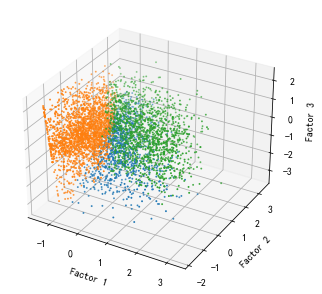

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1250, 2096, 1277]
各个簇的标准差最大分量: [0.9947203326867352, 0.843380563984188, 0.9317069892509775]
各个簇中心间的距离: [1.7709978211378359, 2.1006969090778655, 1.9934786038768135]


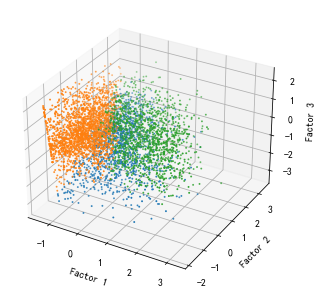

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1390, 2008, 1225]
各个簇的标准差最大分量: [0.9649615589415986, 0.8227809146148534, 0.8784324812455603]
各个簇中心间的距离: [1.7586905358574996, 2.1303915270221165, 2.0447099723958706]


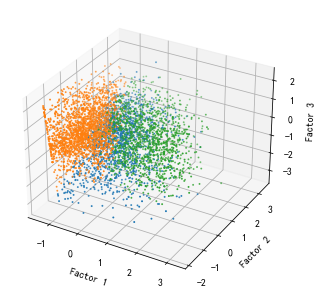

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1474, 1951, 1198]
各个簇的标准差最大分量: [0.9349691503220108, 0.8005593708164274, 0.8519235775400618]
各个簇中心间的距离: [1.7521613158511906, 2.13940448447641, 2.0766470060066746]


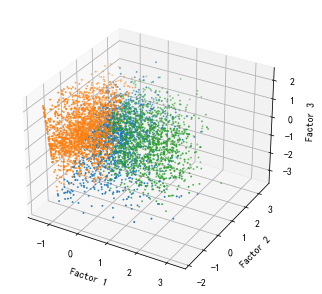

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1530, 1908, 1185]
各个簇的标准差最大分量: [0.912198664004, 0.8007782918360405, 0.8572159176093301]
各个簇中心间的距离: [1.7473163489833492, 2.1423171269973182, 2.096578306952844]


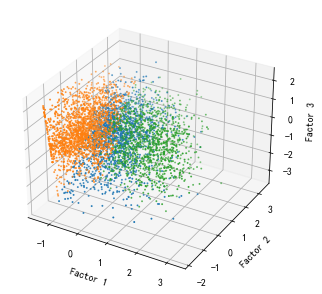

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1564, 1876, 1183]
各个簇的标准差最大分量: [0.9098318586046931, 0.813456286538858, 0.8817334737847586]
各个簇中心间的距离: [1.745647496131135, 2.1413414911458655, 2.1050320412462344]


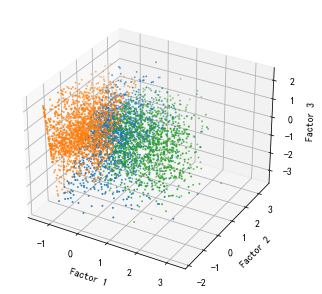

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1591, 1851, 1181]
各个簇的标准差最大分量: [0.9194505945989653, 0.8262930052323401, 0.8962410538489356]
各个簇中心间的距离: [1.7424415048334665, 2.1412781020389136, 2.112605262873411]


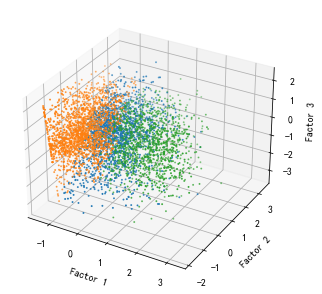

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1598, 1847, 1178]
各个簇的标准差最大分量: [0.9304903811761279, 0.8400875716377163, 0.9051774387075697]
各个簇中心间的距离: [1.744567685043581, 2.1382893793659425, 2.1181434099655148]


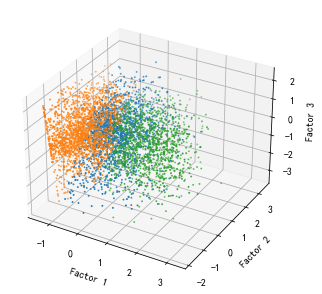

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1638, 1111, 1180]
各个簇的标准差最大分量: [0.8279349006048432, 0.8831351172545858, 0.6941034796157513]
各个簇中心间的距离: [2.174220849826817, 1.7848643561500932, 2.1892024134710346]


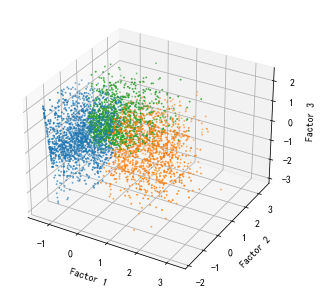

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1648, 1112, 896, 967]
各个簇的标准差最大分量: [0.8940802214936883, 0.93678246937646, 0.6854077115112495, 0.794068466133068]
各个簇中心间的距离: [2.1687733997851177, 1.9187235189509044, 1.9468007867484385, 2.2781365940311744, 2.266002811324093, 1.7070120289999497]


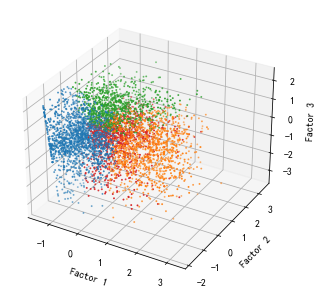

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1534, 1051, 971, 1067]
各个簇的标准差最大分量: [0.8074138457404908, 0.8869132242334714, 0.7385445061857353, 0.8017438096912138]
各个簇中心间的距离: [2.21480762458012, 1.9098940572182783, 1.9145867586823786, 2.3050541551203025, 2.2503765665682733, 1.8336856589421984]


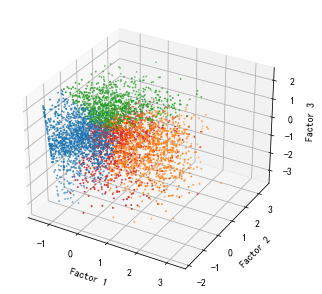

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1477, 1015, 1014, 1117]
各个簇的标准差最大分量: [0.7770073579955322, 0.8641096734201485, 0.7598582883841911, 0.8016173055422908]
各个簇中心间的距离: [2.25044508096158, 1.9067469069258582, 1.8938868415271946, 2.310618906820702, 2.246246206909459, 1.8517643463373639]


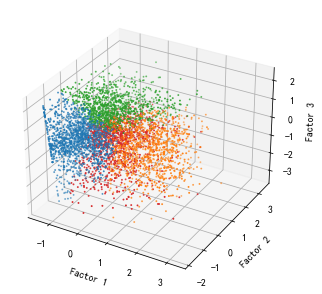

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1453, 996, 1062, 1112]
各个簇的标准差最大分量: [0.7705164251046231, 0.8517702999683567, 0.7646669741811046, 0.7980086209523115]
各个簇中心间的距离: [2.266735571956418, 1.9100670200444594, 1.8840899661058563, 2.3187067678599025, 2.2477941178118286, 1.8529037135290922]


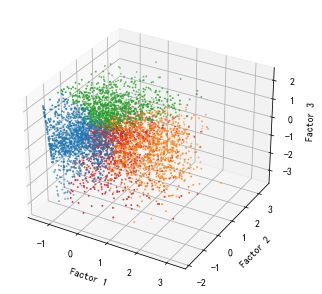

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1428, 993, 1114, 1088]
各个簇的标准差最大分量: [0.7661732280020518, 0.8388934251456486, 0.7642656587898279, 0.7937322088731378]
各个簇中心间的距离: [2.2805502917951355, 1.922449339545091, 1.8734666650342908, 2.3163151592358737, 2.244396872048285, 1.8631823963382783]


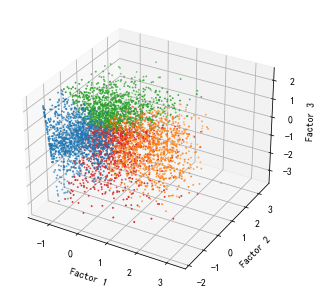

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1407, 991, 1176, 1049]
各个簇的标准差最大分量: [0.7467885094340987, 0.8320938674584458, 0.7567616870044901, 0.7840233353587531]
各个簇中心间的距离: [2.281207775356509, 1.9213705440494986, 1.8823533796548302, 2.3109522927451547, 2.255181459580774, 1.8925832018514959]


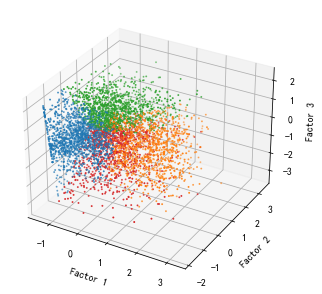

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1398, 998, 1223, 1004]
各个簇的标准差最大分量: [0.7370544467537546, 0.8287788247634427, 0.7381212913701396, 0.7733264193449961]
各个簇中心间的距离: [2.274357473838571, 1.9195485219912651, 1.8996994821051885, 2.299312432584461, 2.276691305879818, 1.9227540506311296]


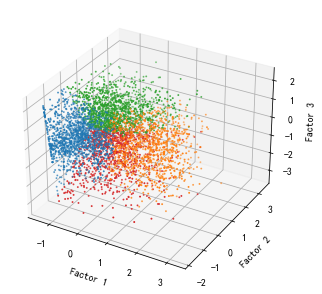

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1395, 1005, 1261, 962]
各个簇的标准差最大分量: [0.7312847767631867, 0.8258615601365257, 0.7176429804529262, 0.7831896886772651]
各个簇中心间的距离: [2.2704736799095815, 1.9118253005710208, 1.9250797144646383, 2.282421119399488, 2.3015048787128958, 1.954050272305322]


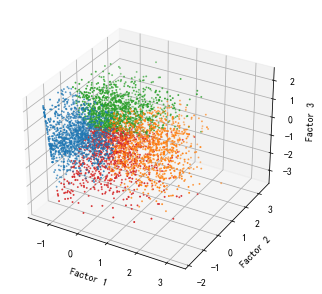

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1404, 1007, 1280, 932]
各个簇的标准差最大分量: [0.7276366390182321, 0.821684999427722, 0.7122941386352414, 0.7938630439931957]
各个簇中心间的距离: [2.2671988264057217, 1.903220983238355, 1.947190196017278, 2.2717424670874493, 2.3195476386706106, 1.9799902758637797]


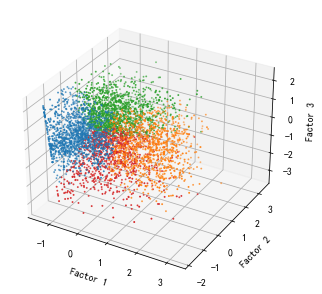

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1412, 1003, 1289, 919]
各个簇的标准差最大分量: [0.7266708924018204, 0.8140573204739283, 0.7172455897384683, 0.7842865714538344]
各个簇中心间的距离: [2.2624126581552937, 1.9057340633747935, 1.9561905244584867, 2.27019481397084, 2.3326023463398613, 1.9938032878922927]


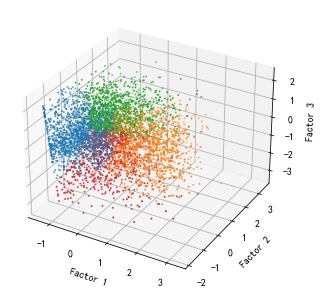

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1423, 1008, 1296, 896]
各个簇的标准差最大分量: [0.7265455707569093, 0.815763113421513, 0.7216894162239375, 0.7803219667937547]
各个簇中心间的距离: [2.2565843345841756, 1.90727173450547, 1.964631875475134, 2.264586331828808, 2.3451101027635888, 2.0045236800208923]


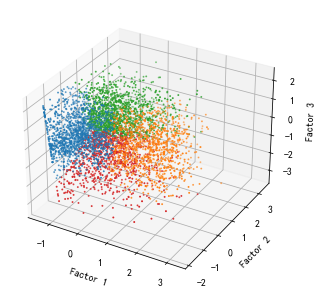

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1432, 1008, 1309, 874]
各个簇的标准差最大分量: [0.7258379535753273, 0.8163351430269637, 0.7268937532780968, 0.7752710044935526]
各个簇中心间的距离: [2.253428141589837, 1.9040523417118924, 1.9736009168747597, 2.263975558182213, 2.3535200915298806, 2.01740535531187]


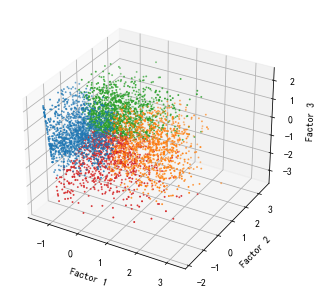

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1443, 1005, 1312, 863]
各个簇的标准差最大分量: [0.7257874258379888, 0.8159790017872471, 0.72788424443682, 0.7765188694672911]
各个簇中心间的距离: [2.253319283599768, 1.8989065925886106, 1.9791669184587413, 2.2656480889494484, 2.3599066497721677, 2.02712036819384]


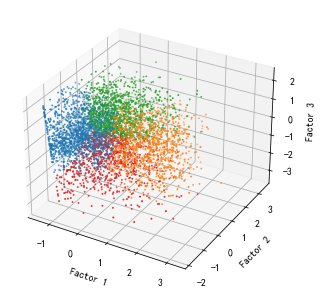

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1449, 1005, 1312, 857]
各个簇的标准差最大分量: [0.7249767767202866, 0.8149561628048259, 0.728351642655314, 0.7785733489018503]
各个簇中心间的距离: [2.2502042556862674, 1.8963675662703723, 1.983880302673049, 2.265978390859143, 2.3628690769452914, 2.0335023454878582]


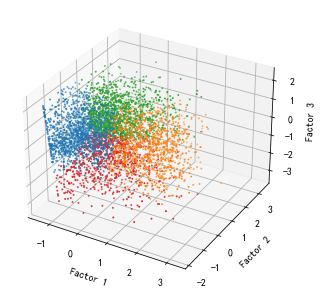

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1452, 1008, 1319, 844]
各个簇的标准差最大分量: [0.7248178092487785, 0.8143841810831114, 0.7349563295485158, 0.7691303611627518]
各个簇中心间的距离: [2.2484306735869555, 1.8964451535604525, 1.9854111633970135, 2.2663900323748205, 2.3614996332233407, 2.0422881482353734]


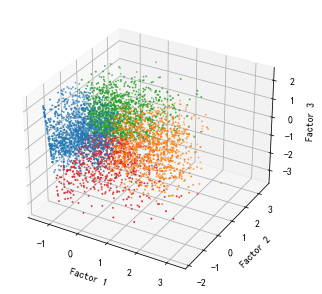

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1452, 1013, 1322, 836]
各个簇的标准差最大分量: [0.724260303681589, 0.814006827698086, 0.7346917392677543, 0.7693270789730574]
各个簇中心间的距离: [2.243309680107007, 1.8948118314469045, 1.9918486966721136, 2.2632922644769033, 2.3653814145464307, 2.0475208270863763]


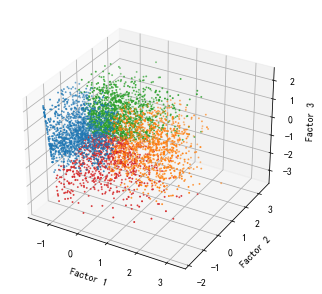

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1455, 1012, 1329, 827]
各个簇的标准差最大分量: [0.7251678330407104, 0.8114617328007601, 0.7366361349161656, 0.7664510457579726]
各个簇中心间的距离: [2.2416205519544796, 1.8926066555889862, 1.9975094634993529, 2.261922722766794, 2.3689959541955274, 2.054641027981982]


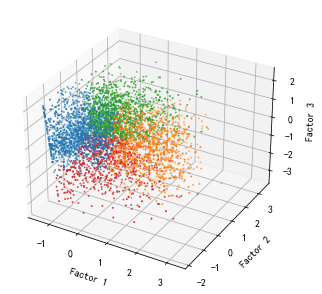

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1458, 1013, 1332, 820]
各个簇的标准差最大分量: [0.7251776660480466, 0.8116677350958016, 0.738610754885011, 0.7641389095449126]
各个簇中心间的距离: [2.2392018856006786, 1.8920736602221055, 2.000050857311144, 2.2622501448226044, 2.3702837221731525, 2.0597262908748326]


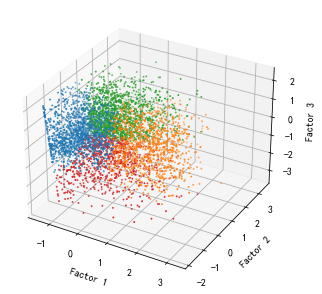

是否需要修改参数,输入“y”确认修改,“n”取消
n
各个簇的样本个数: [1458, 1012, 1335, 818]
各个簇的标准差最大分量: [0.7248220020374851, 0.8108737843044832, 0.7443489260010758, 0.7550721141513254]
各个簇中心间的距离: [2.2403664412418705, 1.8941438192089173, 1.9959611827221577, 2.2636172001615837, 2.3668572911917285, 2.0630510423342048]


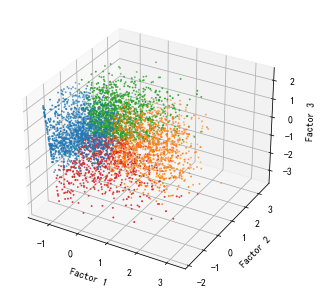

各个簇的样本个数: [1458, 1012, 1335, 818]
各个簇的标准差最大分量: [0.7248220020374851, 0.8108737843044832, 0.7443489260010758, 0.7550721141513254]
各个簇中心间的距离: [2.2403664412418705, 1.8941438192089173, 1.9959611827221577, 2.2636172001615837, 2.3668572911917285, 2.0630510423342048]


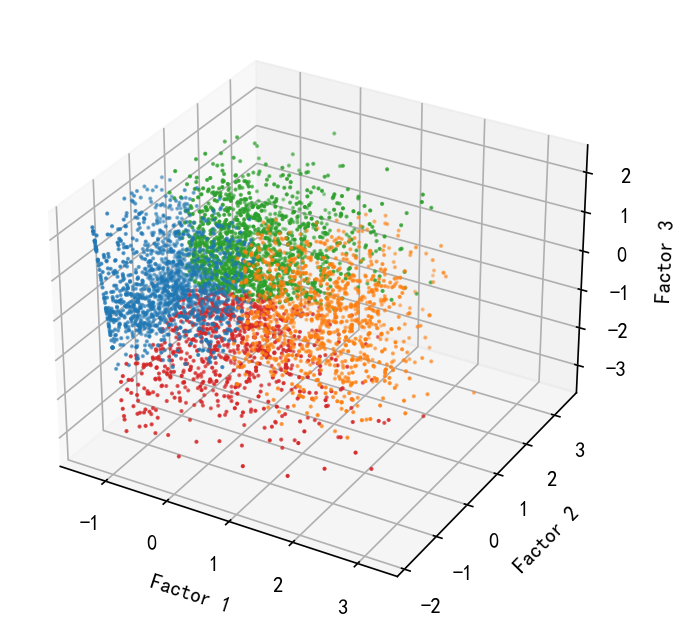

In [214]:
import isodata_cluster
importlib.reload(isodata_cluster)
# initial_set为初始设置集合，依次为nc,K,min_num,s,c,L,I,k
initial_set = [3 , 3 ,800 , 0.95 , 1.6 , 1 , 30 , 0.5]
isodata = isodata_cluster.IsoData(initial_set = initial_set, data = df_feat_new[['f1' , 'f2' , 'f3']].values)
result = isodata.result
# 将ISODATA的结果可视化展示出来
plt.rcParams['figure.dpi'] = 150 #分辨率
cluster_num = []   #记录各个簇的样本数量
cluster_sta = []   #记录各个簇的标准差最大分量
cluster_cen = []   #记录各个簇的簇中心点

fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel("Factor 1") ; ax.set_ylabel("Factor 2") ; ax.set_zlabel("Factor 3") 

for cluster in result:
    df_clu = pd.DataFrame(cluster)
    df_clu.rename(columns = {0 : 'f1' , 1 : 'f2' , 2 : 'f3'} , inplace = True)
    cluster_num.append(df_clu.shape[0])
    cluster_sta.append(get_dis_sta(df_clu))
    cluster_cen.append([df_clu.mean()[0] , df_clu.mean()[1] , df_clu.mean()[2]])
    ax.scatter(df_clu['f1'] , df_clu['f2'] , df_clu['f3'] , s = 1, c=None )
    
dis_cen = get_cen_dis(cluster_cen)
print("各个簇的样本个数:" , cluster_num)
print("各个簇的标准差最大分量:" , cluster_sta)
#print("各个簇的中心坐标值:" , cluster_cen)
print("各个簇中心间的距离:" , dis_cen)
plt.show()

In [215]:
# get the isodata's result's Silhouette Coefficient
df_isodata = pd.DataFrame(columns = ['f1' , 'f2' , 'f3' , 'ISODATA']) 
for i in range(len(result)):
    df_temp = pd.DataFrame(result[i])
    df_temp.rename(columns = {0 : 'f1' , 1 : 'f2' , 2 : 'f3'} , inplace = True)
    df_temp['ISODATA'] = i
    df_isodata = df_isodata.append(df_temp)
df_isodata.reset_index(drop = True , inplace = True)
# 实际上下面这种表联结的方式存在一些问题，因为如果有几辆车的factor1 , factor2 , factor3完全相同的话，
# 那么就会出现他们彼此间两两都会联结的情况了，这就导致样本集的数量增多了，但是这种情况是可以接受的，
# 因为第一出现这种情况的概率是很小的，第二如果两辆车的feature都相同，则必定会被聚到一个类，直接去重是不会影响的。
df_isodata = pd.merge(df_feat_new , df_isodata , on = ['f1' , 'f2' , 'f3'] , how = 'inner')
df_isodata.drop_duplicates(subset=['CAR_NUM'], keep='first', inplace = True)
df_isodata['ISODATA'] = df_isodata['ISODATA'].astype(np.int)  # 将ISODATA这一列转化为np.int类型，使得describe()可以成功对这一列做统计
df_isodata.head(5)

f1        f2        f3  CAR_NUM  DBSCAN        F1        F2  \
0  0.633961  0.057235 -1.165552  浙AFZ391       1  0.047619  0.904762   
1 -0.878013 -0.763536 -0.307468  浙B732UE       0  0.047619  0.428571   
2  1.312621  0.156470  0.043351  浙AN0G37      -1  0.428571  0.952381   
3 -0.335299 -0.023774 -0.200037  浙A3WA22       0  0.047619  0.571429   
4  0.847105  1.263833 -0.014173  浙GN820X      -1  0.476190  0.857143   

         O1        D1        O2        D2        FS    STD_FD    AVG_FD  \
0  0.142857  0.142857  0.571429  0.619048 -2.000000  2.093641  5.125000   
1  0.047619  0.047619  0.047619  0.047619 -1.453860  1.118034  2.333333   
2  0.523810  0.523810  0.523810  0.523810 -0.677038  2.547726  4.909091   
3  0.047619  0.047619  0.285714  0.333333 -1.199703  2.958040  3.666667   
4  0.476190  0.285714  0.285714  0.523810 -0.820671  5.780846  5.727273   

   FastSearch  ISODATA  
0           1        3  
1           0        0  
2           1        1  
3           0        0  
4           1        2

In [216]:
# get the Silhouette Coefficient of the isodata's result.
silhouettevalue = metrics.silhouette_score(df_isodata[['f1' , 'f2' , 'f3']].values , df_isodata['ISODATA'] , metric='euclidean')
silhouettevalue

0.2854265503769039

### Understanding every clusters' statistical characteristic

In [217]:
# get the first cluster's statistical result
df_isodata[df_isodata['ISODATA'] == 0][['F1' , 'F2' , 'O1' , 'D1' , 'O2' , 'D2' , 'FS' , 'STD_FD' , 'AVG_FD' , 'ISODATA']].describe()

F1           F2           O1           D1           O2  \
count  1458.000000  1458.000000  1458.000000  1458.000000  1458.000000   
mean      0.111111     0.373702     0.119244     0.113855     0.108400   
std       0.095205     0.227441     0.106986     0.106393     0.094513   
min       0.047619     0.047619     0.047619     0.047619     0.047619   
25%       0.047619     0.190476     0.047619     0.047619     0.047619   
50%       0.047619     0.333333     0.095238     0.047619     0.095238   
75%       0.142857     0.523810     0.142857     0.142857     0.142857   
max       0.666667     1.000000     0.761905     0.857143     0.714286   

                D2           FS       STD_FD       AVG_FD  ISODATA  
count  1458.000000  1458.000000  1458.000000  1458.000000   1458.0  
mean      0.113103    -0.778688     1.109191     2.657246      0.0  
std       0.096760     0.771450     1.050375     1.722388      0.0  
min       0.047619    -2.539649     0.000000     0.000000      0.0  
25%       0.047619    -1.265825     0.000000     1.500000      0.0  
50%       0.095238    -1.006318     1.000000     2.594118      0.0  
75%       0.142857    -0.295296     1.966384     3.666667      0.0  
max       0.619048     0.992855     4.500000     9.000000      0.0

In [218]:
# get the second cluster's statistical result
df_isodata[df_isodata['ISODATA'] == 1][['F1' , 'F2' , 'O1' , 'D1' , 'O2' , 'D2' , 'FS' , 'STD_FD' , 'AVG_FD' , 'ISODATA']].describe()

F1           F2           O1           D1           O2  \
count  1012.000000  1012.000000  1012.000000  1012.000000  1012.000000   
mean      0.631470     0.882364     0.593356     0.575805     0.512187   
std       0.203464     0.109400     0.194631     0.193829     0.191233   
min       0.047619     0.476190     0.047619     0.047619     0.047619   
25%       0.476190     0.809524     0.476190     0.428571     0.380952   
50%       0.666667     0.904762     0.619048     0.571429     0.523810   
75%       0.761905     1.000000     0.714286     0.714286     0.666667   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                D2           FS       STD_FD       AVG_FD  ISODATA  
count  1012.000000  1012.000000  1012.000000  1012.000000   1012.0  
mean      0.517034    -0.374766     2.083573     3.470499      1.0  
std       0.191682     0.854781     1.461300     1.724281      0.0  
min       0.047619    -2.377553     0.000000     0.000000      1.0  
25%       0.380952    -1.049218     1.000000     2.326923      1.0  
50%       0.523810    -0.446112     2.049390     3.333333      1.0  
75%       0.666667     0.411075     2.968276     4.637987      1.0  
max       1.000000     0.996411     8.082904    10.750000      1.0

In [219]:
# get the third cluster's statistical result
df_isodata[df_isodata['ISODATA'] == 2][['F1' , 'F2' , 'O1' , 'D1' , 'O2' , 'D2' , 'FS' , 'STD_FD' , 'AVG_FD' , 'ISODATA']].describe()

F1           F2           O1           D1           O2  \
count  1335.000000  1335.000000  1335.000000  1335.000000  1335.000000   
mean      0.222008     0.640663     0.187587     0.159979     0.143428   
std       0.189692     0.243896     0.168152     0.150288     0.120821   
min       0.047619     0.047619     0.047619     0.047619     0.047619   
25%       0.047619     0.476190     0.047619     0.047619     0.047619   
50%       0.142857     0.666667     0.142857     0.095238     0.095238   
75%       0.333333     0.857143     0.285714     0.190476     0.190476   
max       1.000000     1.000000     1.000000     0.904762     0.809524   

                D2           FS       STD_FD       AVG_FD  ISODATA  
count  1335.000000  1335.000000  1335.000000  1335.000000   1335.0  
mean      0.166970    -0.808962     4.529741     6.431054      2.0  
std       0.131207     0.809043     1.539201     1.813513      0.0  
min       0.047619    -3.798238     0.000000     2.875000      2.0  
25%       0.095238    -1.307800     3.430258     5.000000      2.0  
50%       0.095238    -1.008589     4.356850     6.142857      2.0  
75%       0.238095    -0.256081     5.501623     7.600000      2.0  
max       0.761905     0.992855     8.927174    11.181818      2.0

In [220]:
# get the third cluster's statistical result
df_isodata[df_isodata['ISODATA'] == 3][['F1' , 'F2' , 'O1' , 'D1' , 'O2' , 'D2' , 'FS' , 'STD_FD' , 'AVG_FD' , 'ISODATA']].describe()

F1          F2          O1          D1          O2          D2  \
count  818.000000  818.000000  818.000000  818.000000  818.000000  818.000000   
mean     0.184538    0.622133    0.203283    0.178368    0.168879    0.180522   
std      0.171614    0.261615    0.193704    0.176193    0.162676    0.169826   
min      0.047619    0.047619    0.047619    0.047619    0.047619    0.047619   
25%      0.047619    0.428571    0.047619    0.047619    0.047619    0.047619   
50%      0.095238    0.666667    0.095238    0.095238    0.095238    0.095238   
75%      0.238095    0.809524    0.333333    0.238095    0.238095    0.238095   
max      0.952381    1.000000    0.857143    0.809524    0.952381    0.904762   

               FS      STD_FD      AVG_FD  ISODATA  
count  818.000000  818.000000  818.000000    818.0  
mean    -2.525216    2.462119    3.801645      3.0  
std      0.812167    1.534517    1.761414      0.0  
min     -4.295169    0.000000    0.000000      3.0  
25%     -3.114484    1.486436    2.666667      3.0  
50%     -2.327513    2.449490    3.700000      3.0  
75%     -1.913535    3.329570    4.794444      3.0  
max     -1.026099    8.897771   10.666667      3.0

## Clustering by fast search and find of density peaks

### Decision Graph Plot

Get the decision graph that is proposed by the paper "Clustering by fast search and find of density peaks". The graph can determine the optimal clustering number. Here i will not determine the optimal clustering number based on this method, but i also plot the decision graph

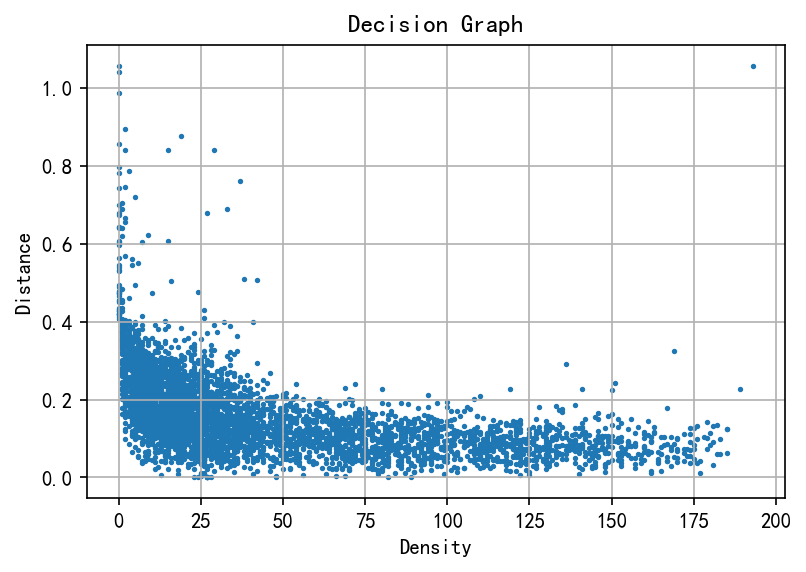

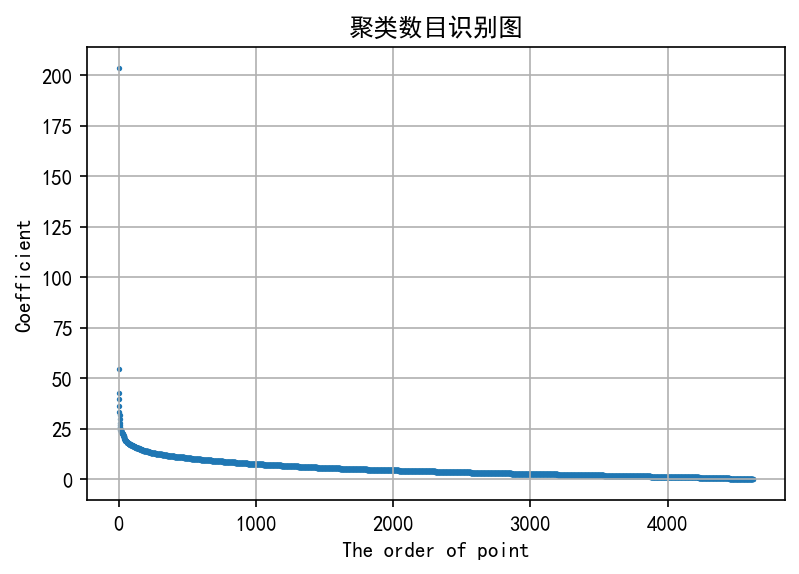

In [117]:
import ClusteringByFastSearchAndFindOfDensityPeaks
importlib.reload(ClusteringByFastSearchAndFindOfDensityPeaks)

data = df_feat_new[['f1' , 'f2' , 'f3']].values
N = len(data)
dist_sample , dc , sample_density , density_rank , n_list , delta_sample = \
    ClusteringByFastSearchAndFindOfDensityPeaks.step1(data , 0.01)
plt.rcParams['font.sans-serif'] = ['SimHei']  #显示中文字符
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号
plt.scatter(sample_density , delta_sample , s = 10 , marker = '.')
plt.grid(True)
plt.xlabel('Density')
plt.ylabel('Distance')
plt.title("Decision Graph")
plt.show()

#识别聚类数目
density_delta_multi = np.multiply(np.array(sample_density),np.array(delta_sample))
density_delta_multi = density_delta_multi.tolist()  #样本的密度数组与样本的距离数组中的对应元素相乘,生成density_delta_multi数组
density_delta_multi_copy = copy.deepcopy(density_delta_multi)  #对density_delta_multi数组进行深拷贝
density_delta_multi_copy.sort(reverse = True)  #对系数按照降序排列
x_axis = [ i for i in range(N)]
plt.scatter(x_axis , density_delta_multi_copy , s = 10 , marker = '.')
plt.grid(True)
plt.xlabel('The order of point')
plt.ylabel('Coefficient')
plt.title("聚类数目识别图")
plt.show()

### Start clustering by fast search and find of density peaks, and display the result

dc: 0.47402132145368003


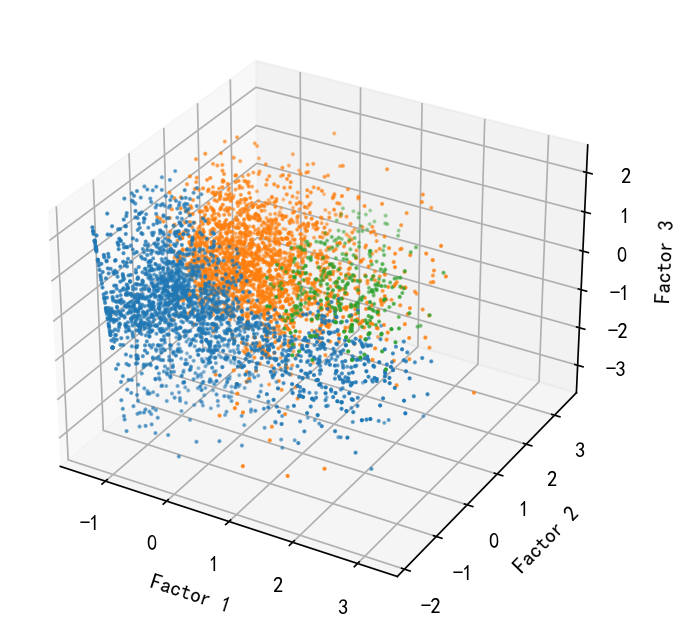

In [123]:
# 进行聚类操作
cluster_center_index , tag_list , tag_core_halo = \
    ClusteringByFastSearchAndFindOfDensityPeaks.fast_search_and_find_density_peaks(\
        data , cluster_num = 3 , t_percent = 0.015)
tag_list = np.array(tag_list)
df_feat_new['FastSearch'] = tag_list

# 绘制出样本的聚类结果中的各个簇
plt.rcParams['font.sans-serif'] = ['SimHei']  #显示中文字符
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号
# plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 150 #分辨率
fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel('Factor 1')
ax.set_ylabel('Factor 2')
ax.set_zlabel('Factor 3')
for i in range(4):
    one_cluster = df_feat_new[['f1' , 'f2' , 'f3']].values[tag_list == i]
    ax.scatter(one_cluster[:,0],one_cluster[:,1],one_cluster[:,2] , s = 1 , c = None)
# plt.savefig("不包含噪声的样本数据分簇情况.png")
plt.show()

### Get every clusters' statistical infomation

In [124]:
# the first cluster's infomation
df_feat_new[['F1' , 'F2' , 'O1' , 'D1' , 'O2' , 'D2' , 'FS' , 'STD_FD' , 'AVG_FD' , 'FastSearch']][df_feat_new['FastSearch'] == 0].describe()

F1           F2           O1           D1           O2  \
count  2190.000000  2190.000000  2190.000000  2190.000000  2190.000000   
mean      0.203914     0.496434     0.213525     0.199674     0.187258   
std       0.230658     0.292899     0.230369     0.220156     0.204025   
min       0.047619     0.047619     0.047619     0.047619     0.047619   
25%       0.047619     0.238095     0.047619     0.047619     0.047619   
50%       0.095238     0.476190     0.095238     0.095238     0.095238   
75%       0.238095     0.761905     0.285714     0.285714     0.238095   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                D2           FS       STD_FD       AVG_FD  FastSearch  
count  2190.000000  2190.000000  2190.000000  2190.000000      2190.0  
mean      0.193107    -1.293739     1.266167     2.641789         0.0  
std       0.204194     1.059593     1.109374     1.545560         0.0  
min       0.047619    -4.295169     0.000000     0.000000         0.0  
25%       0.047619    -1.773418     0.000000     1.625000         0.0  
50%       0.095238    -1.168499     1.258306     2.636364         0.0  
75%       0.238095    -0.794355     2.081666     3.600000         0.0  
max       1.000000     0.992855     5.737305     9.000000         0.0

In [125]:
# the second cluster's infomation
df_feat_new[['F1' , 'F2' , 'O1' , 'D1' , 'O2' , 'D2' , 'FS' , 'STD_FD' , 'AVG_FD' , 'FastSearch']][df_feat_new['FastSearch'] == 1].describe()

F1           F2           O1           D1           O2  \
count  2115.000000  2115.000000  2115.000000  2115.000000  2115.000000   
mean      0.268535     0.673804     0.242193     0.217629     0.195092   
std       0.221040     0.242915     0.209230     0.198685     0.170064   
min       0.047619     0.047619     0.047619     0.047619     0.047619   
25%       0.095238     0.523810     0.095238     0.047619     0.047619   
50%       0.190476     0.714286     0.142857     0.142857     0.142857   
75%       0.428571     0.857143     0.380952     0.333333     0.285714   
max       1.000000     1.000000     1.000000     0.952381     0.904762   

                D2           FS       STD_FD       AVG_FD  FastSearch  
count  2115.000000  2115.000000  2115.000000  2115.000000      2115.0  
mean      0.211753    -0.937688     3.944711     5.738507         1.0  
std       0.171627     0.979741     1.709317     2.000988         0.0  
min       0.047619    -4.272598     0.000000     0.000000         1.0  
25%       0.095238    -1.482893     2.878492     4.379808         1.0  
50%       0.142857    -1.024084     3.800585     5.437500         1.0  
75%       0.333333    -0.226371     4.961595     7.000000         1.0  
max       0.952381     0.996411     8.927174    11.181818         1.0

In [126]:
# the third cluster's infomation
df_feat_new[['F1' , 'F2' , 'O1' , 'D1' , 'O2' , 'D2' , 'FS' , 'STD_FD' , 'AVG_FD' , 'FastSearch']][df_feat_new['FastSearch'] == 2].describe()

F1          F2          O1          D1          O2          D2  \
count  318.000000  318.000000  318.000000  318.000000  318.000000  318.000000   
mean     0.735400    0.911051    0.664121    0.662324    0.576370    0.591045   
std      0.148732    0.086767    0.161586    0.159408    0.171246    0.170775   
min      0.285714    0.619048    0.190476    0.238095    0.142857    0.095238   
25%      0.619048    0.857143    0.571429    0.571429    0.476190    0.476190   
50%      0.761905    0.952381    0.666667    0.666667    0.571429    0.619048   
75%      0.857143    1.000000    0.761905    0.761905    0.714286    0.714286   
max      1.000000    1.000000    1.000000    1.000000    1.000000    0.952381   

               FS      STD_FD      AVG_FD  FastSearch  
count  318.000000  318.000000  318.000000       318.0  
mean     0.491565    2.110143    3.645135         2.0  
std      0.376711    1.464915    1.702781         0.0  
min     -0.593192    0.000000    0.000000         2.0  
25%      0.197497    1.154701    2.616667         2.0  
50%      0.562012    2.081666    3.563492         2.0  
75%      0.833020    3.020530    4.770833         2.0  
max      0.988726    6.626067    8.500000         2.0

**Get the clusters' Silhouette Coefficient**

In [127]:
# get the Silhouette Coefficient of the cluster's result.
silhouettevalue = metrics.silhouette_score(df_feat_new[['f1' , 'f2' , 'f3']].values , df_feat_new['FastSearch'] , metric='euclidean')
silhouettevalue

0.175708763238439

## Get the commuting pattern rule based on decision tree model

**train the decision model**

In [221]:
df_isodata.head(5)

f1        f2        f3  CAR_NUM  DBSCAN        F1        F2  \
0  0.633961  0.057235 -1.165552  浙AFZ391       1  0.047619  0.904762   
1 -0.878013 -0.763536 -0.307468  浙B732UE       0  0.047619  0.428571   
2  1.312621  0.156470  0.043351  浙AN0G37      -1  0.428571  0.952381   
3 -0.335299 -0.023774 -0.200037  浙A3WA22       0  0.047619  0.571429   
4  0.847105  1.263833 -0.014173  浙GN820X      -1  0.476190  0.857143   

         O1        D1        O2        D2        FS    STD_FD    AVG_FD  \
0  0.142857  0.142857  0.571429  0.619048 -2.000000  2.093641  5.125000   
1  0.047619  0.047619  0.047619  0.047619 -1.453860  1.118034  2.333333   
2  0.523810  0.523810  0.523810  0.523810 -0.677038  2.547726  4.909091   
3  0.047619  0.047619  0.285714  0.333333 -1.199703  2.958040  3.666667   
4  0.476190  0.285714  0.285714  0.523810 -0.820671  5.780846  5.727273   

   FastSearch  ISODATA  
0           1        3  
1           0        0  
2           1        1  
3           0        0  
4           1        2

In [222]:
# df_isodata.to_csv("df_isodata.csv" , encoding = 'gbk')

I train the decision tree model based on the isodata result. And i get the best initial parameters of the decision tree model through several attempts, and finally i choose the initial parameters of " max_depth = 6 , min_samples_split = 50 , min_samples_leaf = 20".

In [223]:
df_isodata = pd.read_csv("df_isodata.csv" , encoding = 'gbk')
df_isodata.drop(columns=['Unnamed: 0'] , inplace = True)
df_isodata.head(5)

f1        f2        f3  CAR_NUM  DBSCAN        F1        F2  \
0  0.633961  0.057235 -1.165552  浙AFZ391       1  0.047619  0.904762   
1 -0.878013 -0.763536 -0.307468  浙B732UE       0  0.047619  0.428571   
2  1.312621  0.156470  0.043351  浙AN0G37      -1  0.428571  0.952381   
3 -0.335299 -0.023774 -0.200037  浙A3WA22       0  0.047619  0.571429   
4  0.847105  1.263833 -0.014173  浙GN820X      -1  0.476190  0.857143   

         O1        D1        O2        D2        FS    STD_FD    AVG_FD  \
0  0.142857  0.142857  0.571429  0.619048 -2.000000  2.093641  5.125000   
1  0.047619  0.047619  0.047619  0.047619 -1.453860  1.118034  2.333333   
2  0.523810  0.523810  0.523810  0.523810 -0.677038  2.547726  4.909091   
3  0.047619  0.047619  0.285714  0.333333 -1.199703  2.958040  3.666667   
4  0.476190  0.285714  0.285714  0.523810 -0.820671  5.780846  5.727273   

   FastSearch  ISODATA  
0           1        3  
1           0        0  
2           1        1  
3           0        0  
4           1        2

In [320]:
accurancy_list = []
precision_list = []
recall_list = []

In [321]:
# 绘制决策树模型的图
def plot_decision_tree(dot_data , filename):
    #该函数将生成的决策树可视化出来
    graph = pydotplus.graph_from_dot_data(dot_data)
    graph.get_nodes()[7].set_fillcolor("#FFF2DD")  #指定颜色
    Image(graph.create_png()) #画出这个树
    graph.write_png(filename+ ".png") #保存为png格式

# 计算模型的正确率
def get_correct_ratio(data_test_target , result_prediction):
    '''
    data_test_target:测试集的标签list
    result_prediction:利用建好的树对测试集进行测试后的结果
    return:correct_ratio，模型的正确率
    '''
    N = len(result_prediction)  #测试集样本总个数
    count = 0
    for i in range(len(data_test_target)):
        #print( result_prediction[i])
        if data_test_target[i] == result_prediction[i]:
            count = count + 1
    correct_ratio = count / N
    return correct_ratio

# 划分训练集,测试集
N = len(df_isodata) # total number of sample
train_num = round(0.8 * N)
test_num = N - train_num
df_train = df_isodata[0 : train_num]
df_test = df_isodata[train_num : N]
data_train_target = df_train['ISODATA'].tolist()
data_train_target = [int(i) for i in data_train_target]
for i in range(len(data_train_target)):
    if data_train_target[i] == 1:
        data_train_target[i] = 1
    else:
        data_train_target[i] = 0
data_train = df_train[['F1' , 'F2' , 'O1' , 'D1' , 'O2' , 'D2' , 'FS' , 'STD_FD' , 'AVG_FD']].values
#data_train = data_train.tolist()

data_test_target = df_test['ISODATA'].tolist()
data_test_target = [int(i) for i in data_test_target]
for i in range(len(data_test_target)):
    if data_test_target[i] == 1:
        data_test_target[i] = 1
    else:
        data_test_target[i] = 0
data_test = df_test[['F1' , 'F2' , 'O1' , 'D1' , 'O2' , 'D2' , 'FS' , 'STD_FD' , 'AVG_FD']].values
#data_test = data_test.tolist()

#网格搜索法加交叉验证获取最优决策树模型参数
params_grid = {'max_depth':[2,3,4,5,6,7,8,9,10],'min_samples_leaf':[2,5,10,20,40] , 'min_samples_split':[20,50,80,100],\
               'class_weight' : ['balanced'] , 'random_state':[0] }
estimator = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(estimator,  param_grid =params_grid, n_jobs = -1, verbose = 2 ,cv=5)  
grid_search.fit(data_train , data_train_target)
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    2.4s


0.9451040485681892
{'class_weight': 'balanced', 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 20, 'random_state': 0}
DecisionTreeClassifier(class_weight='balanced', max_depth=9, min_samples_leaf=2,
                       min_samples_split=20, random_state=0)


[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    2.7s finished


In [322]:
'''
该函数用来生成剪之后的决策树
data_train:训练集list
data_train_target:训练集标签
data_test:测试集
data_test_target:测试集标签
min_samples_split_num:表示分裂一个内部节点需要的做少样本数
min_samples_leaf_num:指定每个叶子节点需要的最少样本数
没有返回值,会生成一张决策树的png图片
'''
clf = tree.DecisionTreeClassifier(class_weight='balanced', max_depth=9, min_samples_leaf=2,
                       min_samples_split=20, random_state=0)
clf = clf.fit(data_train , data_train_target)
result_prediction = clf.predict(data_test)
correct_ratio = get_correct_ratio(data_test_target , result_prediction)
print("The correct ratio of the mpdel is : " , correct_ratio)
car_feature_names = ['F1' , 'F2' , 'O1' , 'D1' , 'O2' , 'D2' , 'FS' , 'STD_FD' , 'AVG_FD' ]
car_target_names = ['0' , '1' ]
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names = car_feature_names,  
                      class_names=car_target_names,  
                      filled=True, rounded=True,  
                      special_characters=True)  
plot_decision_tree(dot_data , '决策树结果示意图')
# 保存模型
joblib.dump(clf,  "DecisionTree.pkl")   
# lr是训练好的模型， "./ML/test.pkl"是模型要保存的路径及保存模型的文件名，其中，'pkl' 是sklearn中默认的保存格式gai

The correct ratio of the mpdel is :  0.9491891891891892


['DecisionTree.pkl']

In [323]:
# 得到准确率
accurancy_list.append(accuracy_score(data_test_target, result_prediction))
precision_list.append(precision_score(data_test_target, result_prediction, average='macro'))
recall_list.append(recall_score(data_test_target, result_prediction, average='macro'))
print('accurancy:' ,accuracy_score(data_test_target, result_prediction, normalize=True))
print('macre-precision:' ,precision_score(data_test_target, result_prediction, average='macro')) # precision
print('macro-recall:' , recall_score(data_test_target,result_prediction, average='macro'))  # recall

accurancy: 0.9491891891891892
macre-precision: 0.9151174440610041
macro-recall: 0.9485445457218464


**特征重要性排序**

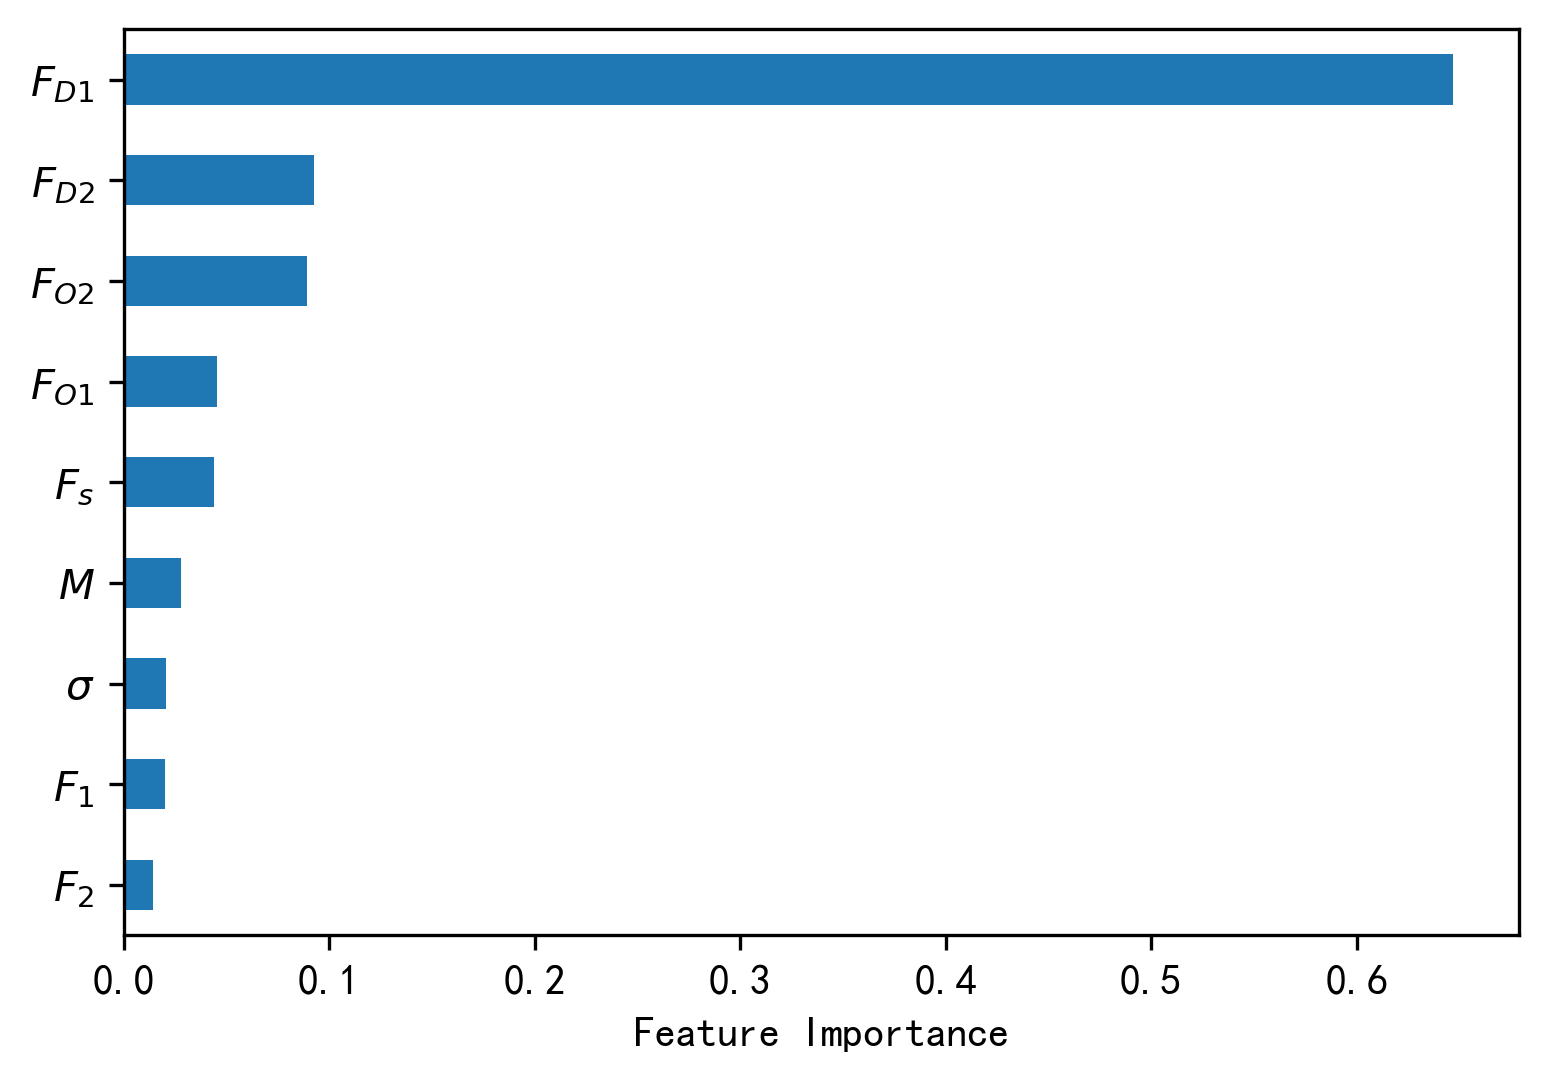

In [324]:
plt.rcParams['figure.dpi'] = 300
importance = clf.feature_importances_
# Impt_Series = pd.Series(importance, index = df_train[['F1' , 'F2' , 'O1' , 'D1' , 'O2' , 'D2' , 'FS' , 'STD_FD' , 'AVG_FD']].columns)
Impt_Series = pd.Series(importance, index = ['$F_1$' ,'$F_2$' , '$F_{O1}$' , '$F_{D1}$' , '$F_{O2}$' , '$F_{D2}$' , '$F_s$' , '$\sigma$' , '$M$'])
Impt_Series.sort_values(ascending = True).plot(kind='barh')
plt.xlabel("Feature Importance")
plt.show()

**不同数目特征下的决策树准确率变化情况**

In [325]:
# 8个特征训练决策树模型
data_train_tmp = data_train[: , [0,2,3,4,5,6,7,8]]
data_test_tmp = data_test[: , [0,2,3,4,5,6,7,8]]
#网格搜索法加交叉验证获取最优决策树模型参数
params_grid = {'max_depth':[2,3,4,5,6,7,8,9,10],'min_samples_leaf':[2,5,10,20,40] , 'min_samples_split':[20,50,80,100],\
               'class_weight' : ['balanced'] , 'random_state':[0] }
estimator = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(estimator,  param_grid =params_grid, n_jobs = -1, verbose = 2 ,cv=5)  
grid_search.fit(data_train_tmp , data_train_target)
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


0.9456416633141937
{'class_weight': 'balanced', 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 20, 'random_state': 0}
DecisionTreeClassifier(class_weight='balanced', max_depth=9, min_samples_leaf=2,
                       min_samples_split=20, random_state=0)


[Parallel(n_jobs=-1)]: Done 861 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    2.5s finished


In [326]:
clf8 = tree.DecisionTreeClassifier(class_weight='balanced', max_depth=9, min_samples_leaf=2,
                       min_samples_split=20, random_state=0)
clf8 = clf8.fit(data_train_tmp , data_train_target)
result_prediction = clf8.predict(data_test_tmp)
correct_ratio = get_correct_ratio(data_test_target , result_prediction)
print("The correct ratio of the mpdel is : " , correct_ratio)
car_feature_names = ['F1' , 'O1' , 'D1' , 'O2' , 'D2' ,'FS', 'STD_FD','AVG_FD']
car_target_names = ['0' , '1' ]
dot_data = tree.export_graphviz(clf8, out_file=None, 
                      feature_names = car_feature_names,  
                      class_names=car_target_names,  
                      filled=True, rounded=True,  
                      special_characters=True)  
plot_decision_tree(dot_data , '决策树结果示意图8')
# 保存模型
joblib.dump(clf8,  "DecisionTree8.pkl")   
# lr是训练好的模型， "./ML/test.pkl"是模型要保存的路径及保存模型的文件名，其中，'pkl' 是sklearn中默认的保存格式gai

The correct ratio of the mpdel is :  0.9535135135135135


['DecisionTree8.pkl']

In [327]:
# 得到准确率
accurancy_list.append(accuracy_score(data_test_target, result_prediction))
precision_list.append(precision_score(data_test_target, result_prediction, average='macro'))
recall_list.append(recall_score(data_test_target, result_prediction, average='macro'))
print('accurancy:' ,accuracy_score(data_test_target, result_prediction, normalize=True))
print('macre-precision:' ,precision_score(data_test_target, result_prediction, average='macro')) # precision
print('macro-recall:' , recall_score(data_test_target,result_prediction, average='macro'))  # recall

accurancy: 0.9535135135135135
macre-precision: 0.9208381263374028
macro-recall: 0.9547258827617546


In [328]:
# 7个特征训练决策树模型
data_train_tmp = data_train[: , [2,3,4,5,6,7,8]]
data_test_tmp = data_test[: ,  [2,3,4,5,6,7,8]]
#网格搜索法加交叉验证获取最优决策树模型参数
params_grid = {'max_depth':[2,3,4,5,6,7,8,9,10],'min_samples_leaf':[2,5,10,20,40] , 'min_samples_split':[20,50,80,100],\
               'class_weight' : ['balanced']  , 'random_state':[0]}
estimator = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(estimator,  param_grid =params_grid, n_jobs = -1, verbose = 2 ,cv=5)  
grid_search.fit(data_train_tmp , data_train_target)
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 793 tasks      | elapsed:    2.5s


0.9405032366602055
{'class_weight': 'balanced', 'max_depth': 9, 'min_samples_leaf': 5, 'min_samples_split': 20, 'random_state': 0}
DecisionTreeClassifier(class_weight='balanced', max_depth=9, min_samples_leaf=5,
                       min_samples_split=20, random_state=0)


[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    2.9s finished


In [329]:
clf7 = tree.DecisionTreeClassifier(class_weight='balanced', max_depth=9, min_samples_leaf=5,
                       min_samples_split=20, random_state=0)
clf7 = clf7.fit(data_train_tmp , data_train_target)
result_prediction = clf7.predict(data_test_tmp)
correct_ratio = get_correct_ratio(data_test_target , result_prediction)
print("The correct ratio of the mpdel is : " , correct_ratio)
car_feature_names = [ 'O1' , 'D1' , 'O2' , 'D2' ,'FS', 'STD_FD','AVG_FD']
car_target_names = ['0' , '1' ]
dot_data = tree.export_graphviz(clf7, out_file=None, 
                      feature_names = car_feature_names,  
                      class_names=car_target_names,  
                      filled=True, rounded=True,  
                      special_characters=True)  
plot_decision_tree(dot_data , '决策树结果示意图7')
# 保存模型
joblib.dump(clf7,  "DecisionTree7.pkl")   
# lr是训练好的模型， "./ML/test.pkl"是模型要保存的路径及保存模型的文件名，其中，'pkl' 是sklearn中默认的保存格式gai

The correct ratio of the mpdel is :  0.9427027027027027


['DecisionTree7.pkl']

In [330]:
# 得到准确率
accurancy_list.append(accuracy_score(data_test_target, result_prediction))
precision_list.append(precision_score(data_test_target, result_prediction, average='macro'))
recall_list.append(recall_score(data_test_target, result_prediction, average='macro'))
print('accurancy:' ,accuracy_score(data_test_target, result_prediction, normalize=True))
print('macre-precision:' ,precision_score(data_test_target, result_prediction, average='macro')) # precision
print('macro-recall:' , recall_score(data_test_target,result_prediction, average='macro'))  # recall

accurancy: 0.9427027027027027
macre-precision: 0.9044708029197079
macro-recall: 0.9443546015877683


In [331]:
# 6个特征训练决策树模型
data_train_tmp = data_train[: , [2,3,4,5,6,8]]
data_test_tmp = data_test[: , [2,3,4,5,6,8]]
#网格搜索法加交叉验证获取最优决策树模型参数
params_grid = {'max_depth':[2,3,4,5,6,7,8,9,10],'min_samples_leaf':[2,5,10,20,40] , 'min_samples_split':[20,50,80,100],\
               'class_weight' : ['balanced'] , 'random_state':[0] }
estimator = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(estimator,  param_grid =params_grid, n_jobs = -1, verbose = 2 ,cv=5)  
grid_search.fit(data_train_tmp , data_train_target)
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed:    2.4s


0.9407753355520608
{'class_weight': 'balanced', 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 20, 'random_state': 0}
DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                       min_samples_leaf=10, min_samples_split=20,
                       random_state=0)


[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    2.7s finished


In [332]:
clf6 = tree.DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                       min_samples_leaf=10, min_samples_split=20,
                       random_state=0)
clf6 = clf6.fit(data_train_tmp , data_train_target)
result_prediction = clf6.predict(data_test_tmp)
correct_ratio = get_correct_ratio(data_test_target , result_prediction)
print("The correct ratio of the mpdel is : " , correct_ratio)
car_feature_names = [ 'O1' , 'D1' , 'O2' , 'D2' ,'FS', 'AVG_FD']
car_target_names = ['0' , '1']
dot_data = tree.export_graphviz(clf6, out_file=None, 
                      feature_names = car_feature_names,  
                      class_names=car_target_names,  
                      filled=True, rounded=True,  
                      special_characters=True)  
plot_decision_tree(dot_data , '决策树结果示意图6')
# 保存模型
joblib.dump(clf6,  "DecisionTree6.pkl")   
# lr是训练好的模型， "./ML/test.pkl"是模型要保存的路径及保存模型的文件名，其中，'pkl' 是sklearn中默认的保存格式gai

The correct ratio of the mpdel is :  0.9437837837837838


['DecisionTree6.pkl']

In [333]:
# 得到准确率
accurancy_list.append(accuracy_score(data_test_target, result_prediction))
precision_list.append(precision_score(data_test_target, result_prediction, average='macro'))
recall_list.append(recall_score(data_test_target, result_prediction, average='macro'))
print('accurancy:' ,accuracy_score(data_test_target, result_prediction, normalize=True))
print('macre-precision:' ,precision_score(data_test_target, result_prediction, average='macro')) # precision
print('macro-recall:' , recall_score(data_test_target,result_prediction, average='macro'))  # recall

accurancy: 0.9437837837837838
macre-precision: 0.9043217286914766
macro-recall: 0.9501349870358986


In [334]:
# 5个特征训练决策树模型
data_train_tmp = data_train[: , [2,3,4,5,6]]
data_test_tmp = data_test[: , [2,3,4,5,6]]
#网格搜索法加交叉验证获取最优决策树模型参数
params_grid = {'max_depth':[2,3,4,5,6,7,8,9,10],'min_samples_leaf':[2,5,10,20,40] , 'min_samples_split':[20,50,80,100],\
               'class_weight' : ['balanced'] , 'random_state':[0]  }
estimator = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(estimator,  param_grid =params_grid, n_jobs = -1, verbose = 2 ,cv=5)  
grid_search.fit(data_train_tmp , data_train_target)
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed:    2.2s


0.9364506455034196
{'class_weight': 'balanced', 'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 20, 'random_state': 0}
DecisionTreeClassifier(class_weight='balanced', max_depth=6, min_samples_leaf=5,
                       min_samples_split=20, random_state=0)


[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    2.6s finished


In [335]:
clf5 = tree.DecisionTreeClassifier(class_weight='balanced', max_depth=6, min_samples_leaf=5,
                       min_samples_split=20, random_state=0)
clf5 = clf5.fit(data_train_tmp , data_train_target)
result_prediction = clf5.predict(data_test_tmp)
correct_ratio = get_correct_ratio(data_test_target , result_prediction)
print("The correct ratio of the mpdel is : " , correct_ratio)
car_feature_names = [ 'O1' , 'D1' , 'O2' , 'D2' ,'FS']
car_target_names = ['0' , '1' ]
dot_data = tree.export_graphviz(clf5, out_file=None, 
                      feature_names = car_feature_names,  
                      class_names=car_target_names,  
                      filled=True, rounded=True,  
                      special_characters=True)  
plot_decision_tree(dot_data , '决策树结果示意图5')
# 保存模型
joblib.dump(clf5,  "DecisionTree5.pkl")   
# lr是训练好的模型， "./ML/test.pkl"是模型要保存的路径及保存模型的文件名，其中，'pkl' 是sklearn中默认的保存格式gai

The correct ratio of the mpdel is :  0.9459459459459459


['DecisionTree5.pkl']

In [336]:
# 得到准确率
accurancy_list.append(accuracy_score(data_test_target, result_prediction))
precision_list.append(precision_score(data_test_target, result_prediction, average='macro'))
recall_list.append(recall_score(data_test_target, result_prediction, average='macro'))
print('accurancy:' ,accuracy_score(data_test_target, result_prediction, normalize=True))
print('macre-precision:' ,precision_score(data_test_target, result_prediction, average='macro')) # precision
print('macro-recall:' , recall_score(data_test_target,result_prediction, average='macro'))  # recall

accurancy: 0.9459459459459459
macre-precision: 0.9104532839962998
macro-recall: 0.9447555531795462


In [337]:
# 4个特征训练决策树模型
data_train_tmp = data_train[: ,[2,3,4,5]]
data_test_tmp = data_test[: , [2,3,4,5]]
#网格搜索法加交叉验证获取最优决策树模型参数
params_grid = {'max_depth':[2,3,4,5,6,7,8,9,10],'min_samples_leaf':[2,5,10,20,40] , 'min_samples_split':[20,50,80,100],\
               'class_weight' : ['balanced'] , 'random_state':[0]  }
estimator = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(estimator,  param_grid =params_grid, n_jobs = -1, verbose = 2 ,cv=5)  
grid_search.fit(data_train_tmp , data_train_target)
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


0.9250970998061663
{'class_weight': 'balanced', 'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 20, 'random_state': 0}
DecisionTreeClassifier(class_weight='balanced', max_depth=8,
                       min_samples_leaf=10, min_samples_split=20,
                       random_state=0)


[Parallel(n_jobs=-1)]: Done 832 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    2.2s finished


In [338]:
clf4 = tree.DecisionTreeClassifier(class_weight='balanced', max_depth=8,
                       min_samples_leaf=10, min_samples_split=20,
                       random_state=0)
clf4 = clf4.fit(data_train_tmp , data_train_target)
result_prediction = clf4.predict(data_test_tmp)
correct_ratio = get_correct_ratio(data_test_target , result_prediction)
print("The correct ratio of the mpdel is : " , correct_ratio)
car_feature_names = [ 'O1' , 'D1' , 'O2' , 'D2']
car_target_names = ['0' , '1' ]
dot_data = tree.export_graphviz(clf4, out_file=None, 
                      feature_names = car_feature_names,  
                      class_names=car_target_names,  
                      filled=True, rounded=True,  
                      special_characters=True)  
plot_decision_tree(dot_data , '决策树结果示意图4')
# 保存模型
joblib.dump(clf4,  "DecisionTree4.pkl")   
# lr是训练好的模型， "./ML/test.pkl"是模型要保存的路径及保存模型的文件名，其中，'pkl' 是sklearn中默认的保存格式gai

The correct ratio of the mpdel is :  0.9340540540540541


['DecisionTree4.pkl']

In [339]:
# 得到准确率
accurancy_list.append(accuracy_score(data_test_target, result_prediction))
precision_list.append(precision_score(data_test_target, result_prediction, average='macro'))
recall_list.append(recall_score(data_test_target, result_prediction, average='macro'))
print('accurancy:' ,accuracy_score(data_test_target, result_prediction, normalize=True))
print('macre-precision:' ,precision_score(data_test_target, result_prediction, average='macro')) # precision
print('macro-recall:' , recall_score(data_test_target,result_prediction, average='macro'))  # recall

accurancy: 0.9340540540540541
macre-precision: 0.8905925925925926
macro-recall: 0.9404620298842586


In [340]:
# 3个特征训练决策树模型
data_train_tmp = data_train[: , [3,4,5]]
data_test_tmp = data_test[: ,[3,4,5]]
#网格搜索法加交叉验证获取最优决策树模型参数
params_grid = {'max_depth':[2,3,4],'min_samples_leaf':[2,5,10,20,40] , 'min_samples_split':[20,50,80,100],\
               'class_weight' : ['balanced'] , 'random_state':[0] }
estimator = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(estimator,  param_grid =params_grid, n_jobs = -1, verbose = 2 ,cv=5)  
grid_search.fit(data_train_tmp , data_train_target)
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


0.9167125041143986
{'class_weight': 'balanced', 'max_depth': 4, 'min_samples_leaf': 20, 'min_samples_split': 80, 'random_state': 0}
DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=20, min_samples_split=80,
                       random_state=0)


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.0s finished


In [341]:
clf3 = tree.DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=20, min_samples_split=80,
                       random_state=0)
clf3 = clf3.fit(data_train_tmp , data_train_target)
result_prediction = clf3.predict(data_test_tmp)
correct_ratio = get_correct_ratio(data_test_target , result_prediction)
print("The correct ratio of the mpdel is : " , correct_ratio)
car_feature_names = [ 'D1' , 'O2' , 'D2']
car_target_names = ['0' , '1']
dot_data = tree.export_graphviz(clf3, out_file=None, 
                      feature_names = car_feature_names,  
                      class_names=car_target_names,  
                      filled=True, rounded=True,  
                      special_characters=True)  
plot_decision_tree(dot_data , '决策树结果示意图3')
# 保存模型
joblib.dump(clf3,  "DecisionTree3.pkl")   
# lr是训练好的模型， "./ML/test.pkl"是模型要保存的路径及保存模型的文件名，其中，'pkl' 是sklearn中默认的保存格式gai

The correct ratio of the mpdel is :  0.9221621621621622


['DecisionTree3.pkl']

In [342]:
# 得到准确率
accurancy_list.append(accuracy_score(data_test_target, result_prediction))
precision_list.append(precision_score(data_test_target, result_prediction, average='macro'))
recall_list.append(recall_score(data_test_target, result_prediction, average='macro'))
print('accurancy:' ,accuracy_score(data_test_target, result_prediction, normalize=True))
print('macre-precision:' ,precision_score(data_test_target, result_prediction, average='macro')) # precision
print('macro-recall:' , recall_score(data_test_target,result_prediction, average='macro'))  # recall

accurancy: 0.9221621621621622
macre-precision: 0.8734305538005582
macro-recall: 0.9344744861137099


In [343]:
# 2个特征训练决策树模型
data_train_tmp = data_train[: , [3,5]]
data_test_tmp = data_test[: , [3,5]]
#网格搜索法加交叉验证获取最优决策树模型参数
params_grid = {'max_depth':[2,3,4],'min_samples_leaf':[2,5,10,20,40] , 'min_samples_split':[20,50,80,100],\
               'class_weight' : ['balanced'], 'random_state':[0] }
estimator = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(estimator,  param_grid =params_grid, n_jobs = -1, verbose = 2 ,cv=5)  
grid_search.fit(data_train_tmp , data_train_target)
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


0.9142767801631131
{'class_weight': 'balanced', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 20, 'random_state': 0}
DecisionTreeClassifier(class_weight='balanced', max_depth=4, min_samples_leaf=2,
                       min_samples_split=20, random_state=0)


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.1s finished


In [344]:
clf2 = tree.DecisionTreeClassifier(class_weight='balanced', max_depth=3, min_samples_leaf=2,
                       min_samples_split=20, random_state=0)
clf2 = clf2.fit(data_train_tmp , data_train_target)
result_prediction = clf2.predict(data_test_tmp)
correct_ratio = get_correct_ratio(data_test_target , result_prediction)
print("The correct ratio of the mpdel is : " , correct_ratio)
car_feature_names = [  'D1' , 'D2' ]
car_target_names = ['0' , '1' ]
dot_data = tree.export_graphviz(clf2, out_file=None, 
                      feature_names = car_feature_names,  
                      class_names=car_target_names,  
                      filled=True, rounded=True,  
                      special_characters=True)  
plot_decision_tree(dot_data , '决策树结果示意图2')
# 保存模型
joblib.dump(clf2,  "DecisionTree2.pkl")   
# lr是训练好的模型， "./ML/test.pkl"是模型要保存的路径及保存模型的文件名，其中，'pkl' 是sklearn中默认的保存格式gai

The correct ratio of the mpdel is :  0.9210810810810811


['DecisionTree2.pkl']

In [345]:
# 得到准确率
accurancy_list.append(accuracy_score(data_test_target, result_prediction))
precision_list.append(precision_score(data_test_target, result_prediction, average='macro'))
recall_list.append(recall_score(data_test_target, result_prediction, average='macro'))
print('accurancy:' ,accuracy_score(data_test_target, result_prediction, normalize=True))
print('macre-precision:' ,precision_score(data_test_target, result_prediction, average='macro')) # precision
print('macro-recall:' , recall_score(data_test_target,result_prediction, average='macro'))  # recall

accurancy: 0.9210810810810811
macre-precision: 0.8724985540775014
macro-recall: 0.9303881211408409


In [346]:
# 1个特征训练决策树模型
data_train_tmp = data_train[: , [3]]
data_test_tmp = data_test[: , [3]]
#网格搜索法加交叉验证获取最优决策树模型参数
params_grid = {'max_depth':[2,3,4,5,6,7,8,9,10],'min_samples_leaf':[2,5,10,20,40] , 'min_samples_split':[20,50,80,100],\
               'class_weight' : ['balanced'], 'random_state':[0]  }
estimator = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(estimator,  param_grid =params_grid, n_jobs = -1, verbose = 2 ,cv=5)  
grid_search.fit(data_train_tmp , data_train_target)
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


0.8720857257799072
{'class_weight': 'balanced', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 20, 'random_state': 0}
DecisionTreeClassifier(class_weight='balanced', max_depth=2, min_samples_leaf=2,
                       min_samples_split=20, random_state=0)


[Parallel(n_jobs=-1)]: Done 882 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    1.9s finished


In [347]:
clf1 = tree.DecisionTreeClassifier(class_weight='balanced', max_depth=2, min_samples_leaf=2,
                       min_samples_split=20, random_state=0)
clf1 = clf1.fit(data_train_tmp , data_train_target)
result_prediction = clf1.predict(data_test_tmp)
correct_ratio = get_correct_ratio(data_test_target , result_prediction)
print("The correct ratio of the mpdel is : " , correct_ratio)
car_feature_names = [  'D1' ]
car_target_names = ['0' , '1' ]
dot_data = tree.export_graphviz(clf1, out_file=None, 
                      feature_names = car_feature_names,  
                      class_names=car_target_names,  
                      filled=True, rounded=True,  
                      special_characters=True)  
plot_decision_tree(dot_data , '决策树结果示意图1')
# 保存模型
joblib.dump(clf1,  "DecisionTree1.pkl")   
# lr是训练好的模型， "./ML/test.pkl"是模型要保存的路径及保存模型的文件名，其中，'pkl' 是sklearn中默认的保存格式gai

The correct ratio of the mpdel is :  0.8918918918918919


['DecisionTree1.pkl']

In [348]:
# 得到准确率
accurancy_list.append(accuracy_score(data_test_target, result_prediction))
precision_list.append(precision_score(data_test_target, result_prediction, average='macro'))
recall_list.append(recall_score(data_test_target, result_prediction, average='macro'))
print('accurancy:' ,accuracy_score(data_test_target, result_prediction, normalize=True))
print('macre-precision:' ,precision_score(data_test_target, result_prediction, average='macro')) # precision
print('macro-recall:' , recall_score(data_test_target,result_prediction, average='macro'))  # recall

accurancy: 0.8918918918918919
macre-precision: 0.8361055237505802
macro-recall: 0.9064513111117052


**绘制出使用不同数目的特征的3个模型评价指标的变化情况**

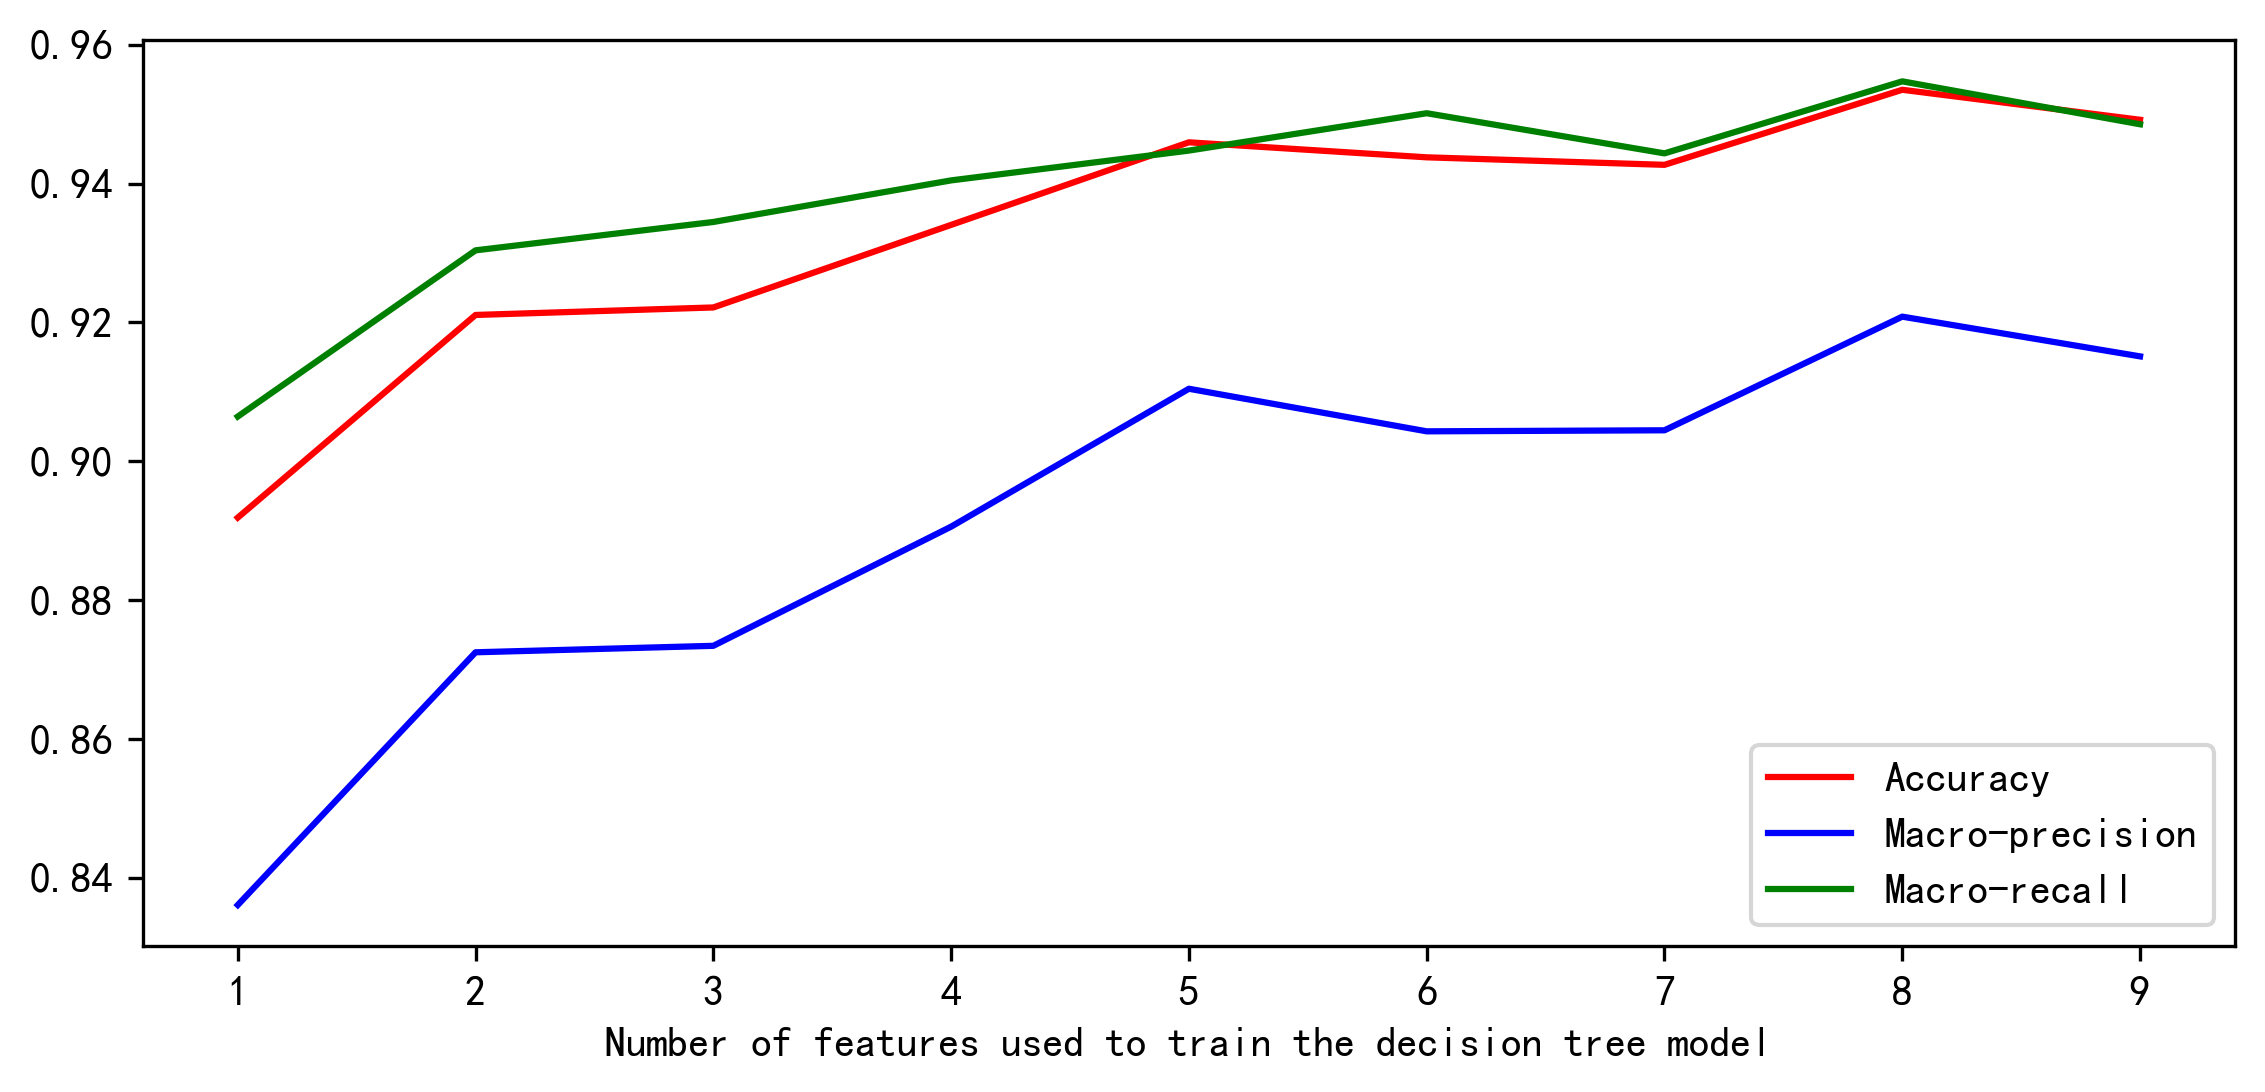

In [349]:
# 将使用不同特征时的准确性，召回率等指标的折线图绘制出来
x_axis = [int((9-i)) for i in range(9)]
fig = plt.figure(figsize=(9,4)) # 设置图大小 figsize=(6,3)
my_x_ticks = np.arange(1, 10, 1)
plt.xticks(my_x_ticks)   #设置坐标轴刻度
plt.plot(x_axis , accurancy_list , c='red' , label = 'Accuracy')
plt.plot(x_axis , precision_list , c='blue',label = 'Macro-precision')
plt.plot(x_axis , recall_list , c='green' ,label = 'Macro-recall')
plt.legend(loc='best')
plt.xlabel("Number of features used to train the decision tree model")
plt.show()

## 不同的规则下的准确率和召回率变化情况
通过上述的模型一共可以得到3条通勤规则，通过gini对3条通勤规则进行从小到大排序，然后分别分析仅1条规则时的准确率和召回率，2条规则时的准确率和召回率，依次类推，并绘制出折线图。在此的准确率等和之前决策树的准确率不同.
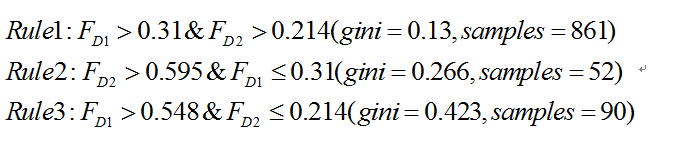

In [367]:
# 得到测试集
N = len(df_isodata) # total number of sample
train_num = round(0.8 * N)
test_num = N - train_num
df_train = df_isodata[0 : train_num]
df_test = df_isodata[train_num : N]
df_test.reset_index(drop = True , inplace = True)
df_test.head(5)

f1        f2        f3  CAR_NUM  DBSCAN        F1        F2  \
0 -0.529897 -1.191786 -1.522080  浙A171LP       2  0.142857  0.285714   
1 -0.552349  0.246508 -0.817364  浙AC5H25       0  0.095238  0.523810   
2 -0.074872  1.004867  0.606384  浙AVJ937      -1  0.333333  0.761905   
3  0.206463 -0.898909  1.392067  浙AQ1T88      -1  0.333333  0.523810   
4  0.214456 -1.021856  1.401926  浙AH5V81      -1  0.428571  0.809524   

         O1        D1        O2        D2        FS    STD_FD    AVG_FD  \
0  0.190476  0.190476  0.047619  0.047619 -2.818446  0.577350  1.666667   
1  0.190476  0.095238  0.047619  0.095238 -2.022806  2.225395  5.571429   
2  0.428571  0.142857  0.142857  0.095238 -0.412582  2.619637  7.937500   
3  0.523810  0.428571  0.238095  0.190476  0.481541  0.707107  2.500000   
4  0.238095  0.142857  0.523810  0.142857  0.675609  0.000000  2.000000   

   FastSearch  ISODATA  
0           0        3  
1           1        3  
2           1        2  
3           1        0  
4           1        0

In [368]:
# 获得正确的标签
y_true = []
tmp = list(df_test['ISODATA'])
for i in range(len(tmp)):
    if tmp[i] == 1:
        y_true.append(1)
    else:
        y_true.append(0)
y_true

[0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [369]:
accurancy_list2 = []
precision_list2 = []
recall_list2 = []

In [370]:
#使用3条规则，即完整的决策树模型进行预测
y_pred = []
for i in range(len(df_test)):
    tmp = df_test.iloc[i,:]
    if tmp['D1'] > 0.31 and tmp['D2'] > 0.214 :  # rule1
        y_pred.append(1)
    elif tmp['D2'] > 0.595 and tmp['D1'] <= 0.31 : # rule2
        y_pred.append(1)
    elif tmp['D1'] > 0.548 and tmp['D2'] <= 0.214: #rule3
        y_pred.append(1)
    else:
        y_pred.append(0)
accurancy_list2.append(accuracy_score(y_true, y_pred))
precision_list2.append(precision_score(y_true, y_pred, average='macro'))
recall_list2.append(recall_score(y_true, y_pred, average='macro'))
print('accurancy:' , accuracy_score(y_true, y_pred))  # accurancy
print('macre-precision:' ,precision_score(y_true, y_pred, average='macro')) # precision
print('macro-recall:' , recall_score(y_true, y_pred, average='macro'))  # recall

accurancy: 0.9210810810810811
macre-precision: 0.8724985540775014
macro-recall: 0.9303881211408409


In [371]:
#使用2条规则，即完整的决策树模型进行预测
y_pred = []
for i in range(len(df_test)):
    tmp = df_test.iloc[i,:]
    if tmp['D1'] > 0.31 and tmp['D2'] > 0.214 :  # rule1
        y_pred.append(1)
    elif tmp['D2'] > 0.595 and tmp['D1'] <= 0.31 : # rule2
        y_pred.append(1)
    else:
        y_pred.append(0)
accurancy_list2.append(accuracy_score(y_true, y_pred))
precision_list2.append(precision_score(y_true, y_pred, average='macro'))
recall_list2.append(recall_score(y_true, y_pred, average='macro'))
print('accurancy:' , accuracy_score(y_true, y_pred))  # accurancy
print('macre-precision:' ,precision_score(y_true, y_pred, average='macro')) # precision
print('macro-recall:' , recall_score(y_true, y_pred, average='macro'))  # recall

accurancy: 0.9232432432432433
macre-precision: 0.8781775835921138
macro-recall: 0.9199266258587047


In [372]:
#使用1条规则，即完整的决策树模型进行预测
y_pred = []
for i in range(len(df_test)):
    tmp = df_test.iloc[i,:]
    if tmp['D1'] > 0.31 and tmp['D2'] > 0.214 :  # rule1
        y_pred.append(1)
    else:
        y_pred.append(0)
accurancy_list2.append(accuracy_score(y_true, y_pred))
precision_list2.append(precision_score(y_true, y_pred, average='macro'))
recall_list2.append(recall_score(y_true, y_pred, average='macro'))
print('accurancy:' , accuracy_score(y_true, y_pred))  # accurancy
print('macre-precision:' ,precision_score(y_true, y_pred, average='macro')) # precision
print('macro-recall:' , recall_score(y_true, y_pred, average='macro'))  # recall

accurancy: 0.9264864864864865
macre-precision: 0.888095238095238
macro-recall: 0.9084694341236534


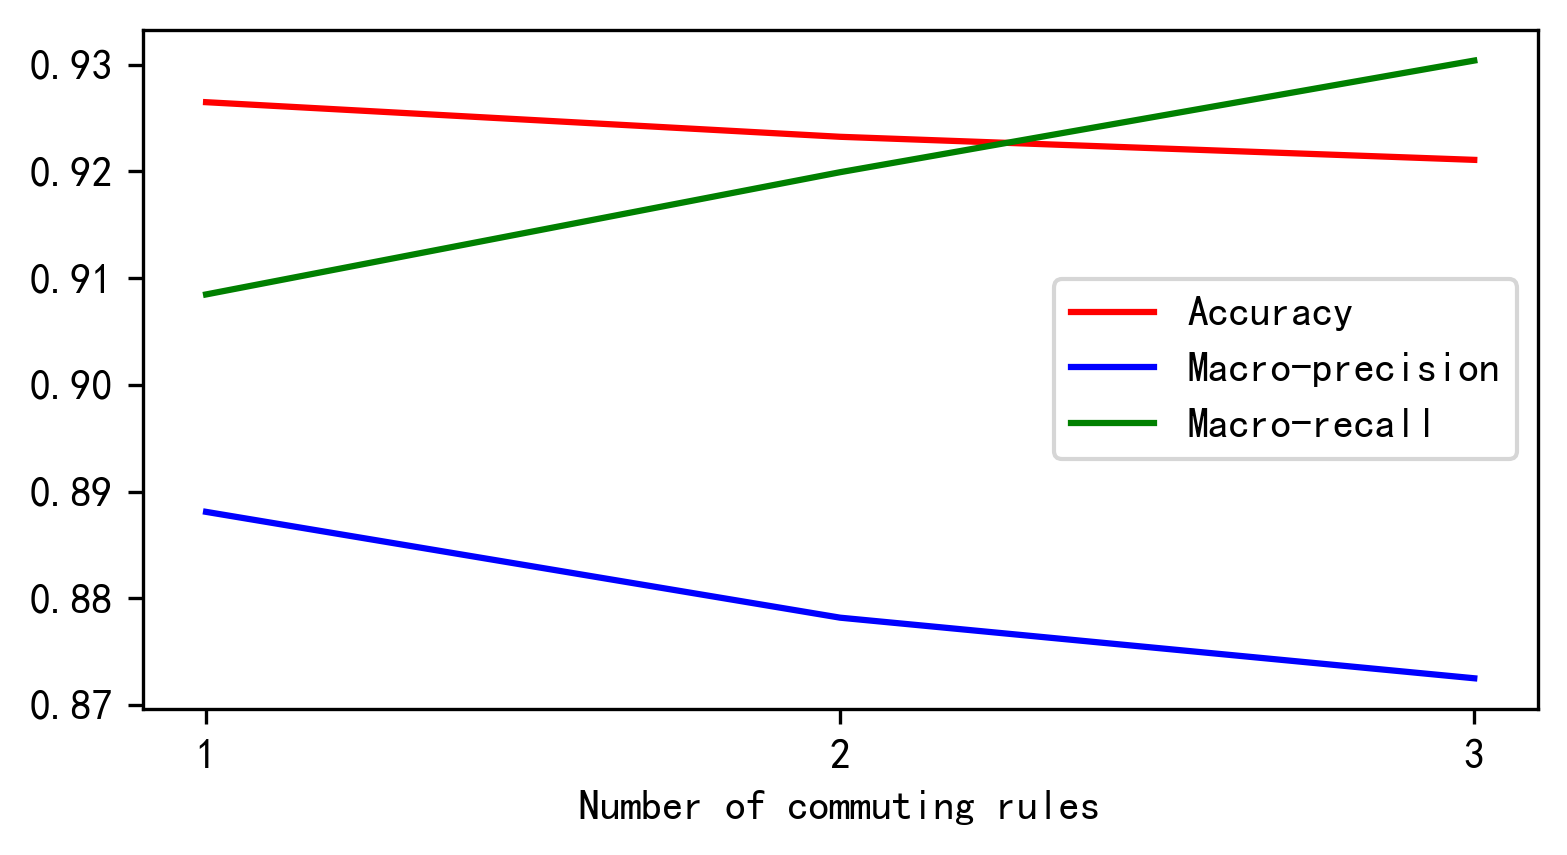

In [373]:
# 将使用不同条数的rule时的准确性，召回率等指标的折线图绘制出来
x_axis = [int((3-i)) for i in range(3)]
fig = plt.figure(figsize=(6,3)) # 设置图大小 figsize=(6,3)
my_x_ticks = np.arange(0, 4, 1)
plt.xticks(my_x_ticks)   #设置坐标轴刻度
plt.plot(x_axis , accurancy_list2 , c='red' , label = 'Accuracy')
plt.plot(x_axis , precision_list2 , c='blue',label = 'Macro-precision')
plt.plot(x_axis , recall_list2 , c='green' ,label = 'Macro-recall')
plt.legend(loc='best')
plt.xlabel("Number of commuting rules")
plt.show()

## 得到决策树模型的更多信息

In [350]:
# 划分训练集,测试集
N = len(df_isodata) # total number of sample
train_num = round(0.8 * N)
test_num = N - train_num
df_train = df_isodata[0 : train_num]
df_test = df_isodata[train_num : N]
data_train_target = df_train['ISODATA'].tolist()
data_train_target = [int(i) for i in data_train_target]
for i in range(len(data_train_target)):
    if data_train_target[i] == 1:
        data_train_target[i] = 1
    else:
        data_train_target[i] = 0
data_train = df_train[['F1' , 'F2' , 'O1' , 'D1' , 'O2' , 'D2' , 'FS' , 'STD_FD' , 'AVG_FD']].values
#data_train = data_train.tolist()

data_test_target = df_test['ISODATA'].tolist()
data_test_target = [int(i) for i in data_test_target]
for i in range(len(data_test_target)):
    if data_test_target[i] == 1:
        data_test_target[i] = 1
    else:
        data_test_target[i] = 0
data_test = df_test[['F1' , 'F2' , 'O1' , 'D1' , 'O2' , 'D2' , 'FS' , 'STD_FD' , 'AVG_FD']].values
#data_test = data_test.tolist()

In [355]:
len(df_train[(df_train['D1'] <= 0.31)&(df_train['D2'] <= 0.405)&(df_train['ISODATA'] != 1)])

2378

In [357]:
len(df_train[(df_train['D1'] <= 0.31)&(df_train['D2'] > 0.405)&(df_train['D2']<=0.595)&(df_train['ISODATA'] != 1)])

94

In [359]:
len(df_train[(df_train['D1'] <= 0.31)&(df_train['D2']>0.405)&(df_train['D2']>0.595)&(df_train['ISODATA'] != 1)])

21

In [361]:
len(df_train[(df_train['D1'] > 0.31)&(df_train['D2']<=0.214)&(df_train['D1']<=0.548)&(df_train['ISODATA'] != 1)])

164

In [363]:
len(df_train[(df_train['D1'] > 0.31)&(df_train['D2']<=0.214)&(df_train['D1']>0.548)&(df_train['ISODATA'] != 1)])

55

In [365]:
len(df_train[(df_train['D1'] > 0.31)&(df_train['D2']>0.214)&(df_train['ISODATA'] != 1)])

183